In [12]:
import os, random, imageio
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange

# -----------------------
# 1) ENVIRONMENT
# -----------------------
class InventoryEnv:
    def __init__(self, min_inv=-10, max_inv=10, T=50):
        self.min_inv = min_inv
        self.max_inv = max_inv
        self.T       = T
        self.reset()

    def reset(self):
        # start at a random inventory within bounds
        self.s = random.randint(self.min_inv, self.max_inv)
        self.t = 0
        return np.array([self.s, self.t], dtype=np.float32)

    def step(self, a):
        # a in {0,1,2} ...
        # random demand:
        w = random.randint(0, 10)
        s2 = self.s + a - w
        s2 = max(self.min_inv, min(self.max_inv, s2))

        # cost structure
        p, a_cost, b_cost = 1, 1, 2
        order_cost = p * a
        inv_cost   = a_cost * s2 if s2 >= 0 else b_cost * (-s2)
        cost       = order_cost + inv_cost

        # reward = negative cost
        r = cost

        # advance time
        self.t += 1
        done = (self.t >= self.T)

        # next state
        self.s = s2
        obs = np.array([self.s, self.t if not done else 0], dtype=np.float32)
        return obs, r, done

# -----------------------
# 2) Q-NETWORK
# -----------------------
class DQN(nn.Module):
    def __init__(self, state_dim, num_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, num_actions), 
            nn.ReLU(),
            nn.Linear(64, 64),        
            nn.ReLU(),
            nn.Linear(64, num_actions)
        )
    def forward(self, x):
        return self.net(x)

# -----------------------
# 3) REPLAY BUFFER
# -----------------------
class ReplayBuffer:
    def __init__(self, cap): self.buf = deque(maxlen=cap)
    def push(self, *args):    self.buf.append(tuple(args))
    def sample(self, k):
        batch = random.sample(self.buf, k)
        return zip(*batch)
    def __len__(self): return len(self.buf)

# -----------------------
# 4) HYPERPARAMETERS
# -----------------------
num_actions      = 3
state_dim        = 2        # [inventory, time]
T                = 50
min_inv, max_inv = -10, 10
gamma            = 1.0
eps_start        = 0.9
eps_end          = 0.05
eps_decay        = 5000
buffer_cap       = 50_000
batch_size       = 32
lr               = 1e-3
target_update    = 10      # steps
episodes         = 2000

# -----------------------
# 5) SETUP
# -----------------------
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
env        = InventoryEnv(min_inv, max_inv, T)
policy_net= DQN(state_dim, num_actions).to(device)
target_net= DQN(state_dim, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
opt        = optim.Adam(policy_net.parameters(), lr=lr)
buf        = ReplayBuffer(buffer_cap)

step_count = 0
eps        = eps_start

# -----------------------
# 6) TRAIN
# -----------------------
for ep in trange(episodes, desc="Training"):
    obs = env.reset()
    done= False
    while not done:
        # ε-greedy
        if random.random() < eps:
            a = random.randrange(num_actions)
        else:
            st = torch.FloatTensor(obs).unsqueeze(0).to(device)
            qv = policy_net(st)
            a  = int(qv.argmin(dim=1).item())

        # step
        obs2, r, done = env.step(a)
        buf.push(obs, a, r, obs2, done)
        obs = obs2

        # learn
        if len(buf) >= batch_size:
            s_batch, a_batch, r_batch, s2_batch, d_batch = buf.sample(batch_size)
            s_v  = torch.FloatTensor(s_batch).to(device)
            a_v  = torch.LongTensor(a_batch).to(device)
            r_v  = torch.FloatTensor(r_batch).to(device)
            s2_v = torch.FloatTensor(s2_batch).to(device)
            d_v  = torch.FloatTensor(d_batch).to(device)

            q_vals = policy_net(s_v).gather(1, a_v.unsqueeze(-1)).squeeze(-1)
            with torch.no_grad():
                q2 = target_net(s2_v)
                q2_min = q2.min(dim=1)[0]
                target = r_v + gamma * q2_min * (1 - d_v)

            loss = nn.MSELoss()(q_vals, target)
            opt.zero_grad(); loss.backward(); opt.step()

            step_count += 1
            if step_count % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

    # decay ε
    # eps = eps_end + (eps_start - eps_end) * np.exp(-ep/eps_decay)
    # dont decay ε 
    eps = eps

print(" Training complete")

# -----------------------
# 7) EXTRACT Q-TABLE & V(s,t)
# -----------------------
policy_net.eval()
num_states = max_inv - min_inv + 1
Q_tab  = np.zeros((T, num_states, num_actions), dtype=np.float32)
V_tab  = np.zeros((T, num_states), dtype=np.float32)
pi_tab = np.zeros((T, num_states), dtype=int)

with torch.no_grad():
    for t in range(T):
        for i, s in enumerate(range(min_inv, max_inv+1)):
            st = torch.FloatTensor([[s, t]]).to(device)
            qs = policy_net(st).cpu().numpy()[0]
            Q_tab[t, i] = qs
            a_opt = int(np.argmin(qs))
            pi_tab[t, i] = a_opt
            V_tab[t, i] = qs[a_opt]

# -----------------------
# 8) COMPUTE σ_t
# -----------------------
# sigma = []
# for t in range(T):
#     row = pi_tab[t]
#     th  = max_inv
#     for i,a in enumerate(row):
#         if a == 0:
#             th = i + min_inv
#             break
#     sigma.append(th)

# print("\nLearned base‐stock thresholds σ_t (first 20):")
# for t in range(20):
#     print(f" t={t:3d}  σ_t = {sigma[t]:4d}")
# print("  ...")

# -----------------------
# 9) ROLLOUT DEMO
# -----------------------
print("\nTime | Inv | Demand | Action")
print("------------------------------------")
s = 0
for t in range(T):
    w = random.randint(0,10)
    a = pi_tab[t, s-min_inv]
    print(f"{t:4d} | {s:4d} | {w:6d} | {a:6d}")
    s = max(min_inv, min(max_inv, s + a - w))

# -----------------------
# 10) PLOT SLICES of V(s)
# -----------------------
states = np.arange(min_inv, max_inv+1)
# for t in [0, 25, 50, 75, 99]:
#     plt.figure(figsize=(6,4))
#     plt.plot(states, V_tab[t], marker='o')
#     plt.title(f"V(s) at t={t}"); plt.xlabel("Inventory"); plt.ylabel("Value")
#     plt.grid(); plt.show()

# -----------------------
# 11) GIF of V(s) over t
# -----------------------
os.makedirs("frames", exist_ok=True)
for t in range(T):
    plt.figure(figsize=(4,3))
    plt.plot(states, V_tab[t], marker='o')
    plt.title(f"t={t}"); plt.tight_layout()
    fn = f"frames/{t:03d}.png"
    plt.savefig(fn); plt.close()

with imageio.get_writer("vf_evolution_ar_6.gif", mode="I", duration=0.1) as w:
    for t in range(T):
        w.append_data(imageio.imread(f"frames/{t:03d}.png"))

import shutil; shutil.rmtree("frames")
print("GIF saved as vf_evolution_ar_6.gif")


cuda


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Same code as above, just added code for monitoring Q-Values

cuda


Training:   0%|          | 0/3000 [00:00<?, ?it/s]

Training:   2%|▏         | 52/3000 [00:07<06:40,  7.35it/s]

[Episode 50] Max Q-value diff at t=0: 1334.623657


Training:   3%|▎         | 102/3000 [00:13<06:35,  7.33it/s]

[Episode 100] Max Q-value diff at t=0: 256.351562


Training:   5%|▌         | 152/3000 [00:19<05:59,  7.92it/s]

[Episode 150] Max Q-value diff at t=0: 90.700745


Training:   7%|▋         | 202/3000 [00:25<06:27,  7.21it/s]

[Episode 200] Max Q-value diff at t=0: 127.403809


Training:   8%|▊         | 252/3000 [00:32<06:16,  7.31it/s]

[Episode 250] Max Q-value diff at t=0: 60.177612


Training:  10%|█         | 302/3000 [00:39<06:12,  7.24it/s]

[Episode 300] Max Q-value diff at t=0: 62.432129


Training:  12%|█▏        | 352/3000 [00:45<06:06,  7.23it/s]

[Episode 350] Max Q-value diff at t=0: 61.157166


Training:  13%|█▎        | 402/3000 [00:51<04:43,  9.16it/s]

[Episode 400] Max Q-value diff at t=0: 109.991333


Training:  15%|█▌        | 452/3000 [00:57<05:51,  7.25it/s]

[Episode 450] Max Q-value diff at t=0: 95.103394


Training:  17%|█▋        | 502/3000 [01:03<05:46,  7.21it/s]

[Episode 500] Max Q-value diff at t=0: 90.485413


Training:  18%|█▊        | 552/3000 [01:10<05:42,  7.16it/s]

[Episode 550] Max Q-value diff at t=0: 96.133423


Training:  20%|██        | 602/3000 [01:17<05:35,  7.14it/s]

[Episode 600] Max Q-value diff at t=0: 86.837402


Training:  22%|██▏       | 652/3000 [01:24<05:58,  6.55it/s]

[Episode 650] Max Q-value diff at t=0: 139.234009


Training:  23%|██▎       | 702/3000 [01:31<05:46,  6.62it/s]

[Episode 700] Max Q-value diff at t=0: 172.970520


Training:  25%|██▌       | 752/3000 [01:39<05:29,  6.82it/s]

[Episode 750] Max Q-value diff at t=0: 140.715942


Training:  27%|██▋       | 802/3000 [01:46<05:08,  7.11it/s]

[Episode 800] Max Q-value diff at t=0: 143.508789


Training:  28%|██▊       | 852/3000 [01:53<04:59,  7.18it/s]

[Episode 850] Max Q-value diff at t=0: 56.324402


Training:  30%|███       | 902/3000 [01:59<04:53,  7.16it/s]

[Episode 900] Max Q-value diff at t=0: 70.671875


Training:  32%|███▏      | 952/3000 [02:06<04:44,  7.19it/s]

[Episode 950] Max Q-value diff at t=0: 52.410767


Training:  33%|███▎      | 1002/3000 [02:13<04:38,  7.18it/s]

[Episode 1000] Max Q-value diff at t=0: 145.805298


Training:  35%|███▌      | 1052/3000 [02:19<04:32,  7.16it/s]

[Episode 1050] Max Q-value diff at t=0: 274.505615


Training:  37%|███▋      | 1102/3000 [02:26<04:25,  7.14it/s]

[Episode 1100] Max Q-value diff at t=0: 50.272339


Training:  38%|███▊      | 1152/3000 [02:33<04:20,  7.09it/s]

[Episode 1150] Max Q-value diff at t=0: 66.356995


Training:  40%|████      | 1202/3000 [02:40<04:13,  7.09it/s]

[Episode 1200] Max Q-value diff at t=0: 110.987305


Training:  42%|████▏     | 1252/3000 [02:47<04:04,  7.14it/s]

[Episode 1250] Max Q-value diff at t=0: 61.845886


Training:  43%|████▎     | 1302/3000 [02:53<03:57,  7.14it/s]

[Episode 1300] Max Q-value diff at t=0: 51.946960


Training:  45%|████▌     | 1352/3000 [03:00<03:53,  7.06it/s]

[Episode 1350] Max Q-value diff at t=0: 77.501404


Training:  47%|████▋     | 1402/3000 [03:07<03:41,  7.20it/s]

[Episode 1400] Max Q-value diff at t=0: 108.556152


Training:  48%|████▊     | 1452/3000 [03:14<03:36,  7.15it/s]

[Episode 1450] Max Q-value diff at t=0: 142.064453


Training:  50%|█████     | 1502/3000 [03:21<03:30,  7.13it/s]

[Episode 1500] Max Q-value diff at t=0: 97.299927


Training:  52%|█████▏    | 1552/3000 [03:27<03:23,  7.10it/s]

[Episode 1550] Max Q-value diff at t=0: 47.451904


Training:  53%|█████▎    | 1602/3000 [03:34<03:15,  7.14it/s]

[Episode 1600] Max Q-value diff at t=0: 149.066101


Training:  55%|█████▌    | 1652/3000 [03:40<03:10,  7.08it/s]

[Episode 1650] Max Q-value diff at t=0: 78.296936


Training:  57%|█████▋    | 1702/3000 [03:47<03:00,  7.20it/s]

[Episode 1700] Max Q-value diff at t=0: 122.596802


Training:  58%|█████▊    | 1752/3000 [03:54<02:55,  7.09it/s]

[Episode 1750] Max Q-value diff at t=0: 64.429688


Training:  60%|██████    | 1802/3000 [04:00<02:13,  8.97it/s]

[Episode 1800] Max Q-value diff at t=0: 43.922485


Training:  62%|██████▏   | 1852/3000 [04:05<02:10,  8.81it/s]

[Episode 1850] Max Q-value diff at t=0: 163.776794


Training:  63%|██████▎   | 1902/3000 [04:10<02:02,  8.98it/s]

[Episode 1900] Max Q-value diff at t=0: 184.184509


Training:  65%|██████▌   | 1952/3000 [04:17<02:27,  7.11it/s]

[Episode 1950] Max Q-value diff at t=0: 76.496704


Training:  67%|██████▋   | 2002/3000 [04:24<02:19,  7.13it/s]

[Episode 2000] Max Q-value diff at t=0: 73.406921


Training:  68%|██████▊   | 2052/3000 [04:31<02:13,  7.11it/s]

[Episode 2050] Max Q-value diff at t=0: 55.971375


Training:  70%|███████   | 2102/3000 [04:37<02:05,  7.16it/s]

[Episode 2100] Max Q-value diff at t=0: 85.391968


Training:  72%|███████▏  | 2152/3000 [04:44<01:58,  7.14it/s]

[Episode 2150] Max Q-value diff at t=0: 99.891357


Training:  73%|███████▎  | 2202/3000 [04:51<01:52,  7.12it/s]

[Episode 2200] Max Q-value diff at t=0: 126.333252


Training:  75%|███████▌  | 2252/3000 [04:58<01:45,  7.11it/s]

[Episode 2250] Max Q-value diff at t=0: 31.623901


Training:  77%|███████▋  | 2302/3000 [05:04<01:37,  7.15it/s]

[Episode 2300] Max Q-value diff at t=0: 159.464722


Training:  78%|███████▊  | 2352/3000 [05:11<01:30,  7.19it/s]

[Episode 2350] Max Q-value diff at t=0: 184.880127


Training:  80%|████████  | 2402/3000 [05:18<01:24,  7.09it/s]

[Episode 2400] Max Q-value diff at t=0: 50.062744


Training:  82%|████████▏ | 2452/3000 [05:25<01:07,  8.08it/s]

[Episode 2450] Max Q-value diff at t=0: 177.298828


Training:  83%|████████▎ | 2502/3000 [05:31<01:10,  7.09it/s]

[Episode 2500] Max Q-value diff at t=0: 133.057373


Training:  85%|████████▌ | 2552/3000 [05:38<01:02,  7.13it/s]

[Episode 2550] Max Q-value diff at t=0: 56.086304


Training:  87%|████████▋ | 2602/3000 [05:45<00:55,  7.13it/s]

[Episode 2600] Max Q-value diff at t=0: 78.437927


Training:  88%|████████▊ | 2652/3000 [05:52<00:48,  7.15it/s]

[Episode 2650] Max Q-value diff at t=0: 76.972656


Training:  90%|█████████ | 2702/3000 [05:59<00:41,  7.19it/s]

[Episode 2700] Max Q-value diff at t=0: 96.571899


Training:  92%|█████████▏| 2752/3000 [06:05<00:34,  7.19it/s]

[Episode 2750] Max Q-value diff at t=0: 133.134399


Training:  93%|█████████▎| 2802/3000 [06:12<00:27,  7.19it/s]

[Episode 2800] Max Q-value diff at t=0: 63.192200


Training:  95%|█████████▌| 2852/3000 [06:19<00:20,  7.25it/s]

[Episode 2850] Max Q-value diff at t=0: 52.848999


Training:  97%|█████████▋| 2902/3000 [06:25<00:13,  7.15it/s]

[Episode 2900] Max Q-value diff at t=0: 110.560852


Training:  98%|█████████▊| 2952/3000 [06:32<00:06,  7.06it/s]

[Episode 2950] Max Q-value diff at t=0: 89.894409


Training: 100%|██████████| 3000/3000 [06:39<00:00,  7.52it/s]


Training complete


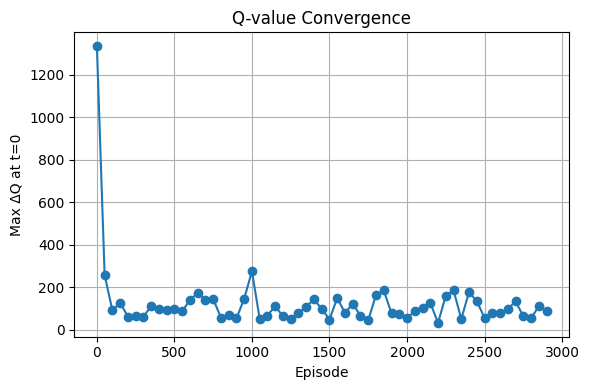


Time | Inv | Demand | Action
------------------------------------
   0 |    0 |     10 |      8
   1 |   -2 |      6 |      8
   2 |    0 |      5 |      8
   3 |    3 |      5 |      8
   4 |    6 |      4 |      8
   5 |   10 |      7 |      1
   6 |    4 |      4 |      8
   7 |    8 |      4 |      8
   8 |   12 |      6 |      1
   9 |    7 |      2 |      8
  10 |   13 |     10 |      1
  11 |    4 |      7 |      8
  12 |    5 |      8 |      8
  13 |    5 |      6 |      8
  14 |    7 |      4 |      8
  15 |   11 |      5 |      1
  16 |    7 |      4 |      8
  17 |   11 |      4 |      1
  18 |    8 |      0 |      1
  19 |    9 |      5 |      1
  20 |    5 |      1 |      8
  21 |   12 |      5 |      1
  22 |    8 |      3 |      1
  23 |    6 |     10 |      8
  24 |    4 |      3 |      8
  25 |    9 |      3 |      1
  26 |    7 |      7 |      3
  27 |    3 |      3 |      8
  28 |    8 |      1 |      1
  29 |    8 |     10 |      1
  30 |   -1 |      7 |      8
  3

/tmp/ipykernel_37148/1719437843.py:226: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  w.append_data(imageio.imread(f"frames/{t:03d}.png"))


GIF saved as vf_evolution_ar_12.gif


In [16]:
import os, random, imageio, shutil
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange

# -----------------------
# 1) ENVIRONMENT
# -----------------------
class InventoryEnv:
    def __init__(self, min_inv=-50, max_inv=50, T=50):
        self.min_inv = min_inv
        self.max_inv = max_inv
        self.T       = T
        self.reset()

    def reset(self):
        self.s = random.randint(self.min_inv, self.max_inv)
        self.t = 0
        return np.array([self.s, self.t], dtype=np.float32)

    def step(self, a):
        w = random.randint(0, 10)
        s2 = self.s + a - w
        s2 = max(self.min_inv, min(self.max_inv, s2))

        p, a_cost, b_cost = 1, 1, 2
        order_cost = p * a
        inv_cost   = a_cost * s2 if s2 >= 0 else b_cost * (-s2)
        cost       = order_cost + inv_cost
        r = cost

        self.t += 1
        done = (self.t >= self.T)
        self.s = s2
        obs = np.array([self.s, self.t if not done else 0], dtype=np.float32)
        return obs, r, done

# -----------------------
# 2) Q-NETWORK
# -----------------------
class DQN(nn.Module):
    def __init__(self, state_dim, num_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, num_actions)
        )
    def forward(self, x):
        return self.net(x)

# -----------------------
# 3) REPLAY BUFFER
# -----------------------
class ReplayBuffer:
    def __init__(self, cap): self.buf = deque(maxlen=cap)
    def push(self, *args):    self.buf.append(tuple(args))
    def sample(self, k):
        batch = random.sample(self.buf, k)
        return zip(*batch)
    def __len__(self): return len(self.buf)

# -----------------------
# 4) HYPERPARAMETERS
# -----------------------
num_actions      = 10
state_dim        = 2
T                = 50
min_inv, max_inv = -50, 50
gamma            = 1.0
eps_start        = 0.9
eps_end          = 0.05
eps_decay        = 5000
buffer_cap       = 50_000
batch_size       = 32
lr               = 1e-3
target_update    = 10
episodes         = 3000

# -----------------------
# 5) SETUP
# -----------------------
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
env        = InventoryEnv(min_inv, max_inv, T)
policy_net = DQN(state_dim, num_actions).to(device)
target_net = DQN(state_dim, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
opt        = optim.Adam(policy_net.parameters(), lr=lr)
buf        = ReplayBuffer(buffer_cap)

step_count = 0
eps        = eps_start

# For Q-value convergence check
q_convergence = []
prev_q_snapshot = None
check_convergence_interval = 50

# -----------------------
# 6) TRAIN
# -----------------------
for ep in trange(episodes, desc="Training"):
    obs = env.reset()
    done= False
    while not done:
        if random.random() < eps:
            a = random.randrange(num_actions)
        else:
            st = torch.FloatTensor(obs).unsqueeze(0).to(device)
            qv = policy_net(st)
            a  = int(qv.argmin(dim=1).item())

        obs2, r, done = env.step(a)
        buf.push(obs, a, r, obs2, done)
        obs = obs2

        if len(buf) >= batch_size:
            s_batch, a_batch, r_batch, s2_batch, d_batch = buf.sample(batch_size)
            s_v  = torch.FloatTensor(s_batch).to(device)
            a_v  = torch.LongTensor(a_batch).to(device)
            r_v  = torch.FloatTensor(r_batch).to(device)
            s2_v = torch.FloatTensor(s2_batch).to(device)
            d_v  = torch.FloatTensor(d_batch).to(device)

            q_vals = policy_net(s_v).gather(1, a_v.unsqueeze(-1)).squeeze(-1)
            with torch.no_grad():
                q2 = target_net(s2_v)
                q2_min = q2.min(dim=1)[0]
                target = r_v + gamma * q2_min * (1 - d_v)

            loss = nn.MSELoss()(q_vals, target)
            opt.zero_grad(); loss.backward(); opt.step()

            step_count += 1
            if step_count % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

    # Don't decay ε
    eps = eps

    # Check Q-value convergence
    if ep % check_convergence_interval == 0:
        with torch.no_grad():
            q_snapshot = []
            for i, s in enumerate(range(min_inv, max_inv+1)):
                st = torch.FloatTensor([[s, 0]]).to(device)
                qs = policy_net(st).cpu().numpy()[0]
                q_snapshot.append(qs)
            q_snapshot = np.array(q_snapshot)

        if prev_q_snapshot is not None:
            diff = np.abs(prev_q_snapshot - q_snapshot)
            max_diff = np.max(diff)
            q_convergence.append(max_diff)
            print(f"[Episode {ep}] Max Q-value diff at t=0: {max_diff:.6f}")
        prev_q_snapshot = q_snapshot

print("Training complete")

# -----------------------
# Plot Q-value convergence
# -----------------------
if q_convergence:
    plt.figure(figsize=(6, 4))
    plt.plot(np.arange(len(q_convergence)) * check_convergence_interval, q_convergence, marker='o')
    plt.xlabel("Episode")
    plt.ylabel("Max ΔQ at t=0")
    plt.title("Q-value Convergence")
    plt.grid()
    plt.tight_layout()
    plt.show()

# -----------------------
# 7) EXTRACT Q-TABLE & V(s,t)
# -----------------------
policy_net.eval()
num_states = max_inv - min_inv + 1
Q_tab  = np.zeros((T, num_states, num_actions), dtype=np.float32)
V_tab  = np.zeros((T, num_states), dtype=np.float32)
pi_tab = np.zeros((T, num_states), dtype=int)

with torch.no_grad():
    for t in range(T):
        for i, s in enumerate(range(min_inv, max_inv+1)):
            st = torch.FloatTensor([[s, t]]).to(device)
            qs = policy_net(st).cpu().numpy()[0]
            Q_tab[t, i] = qs
            a_opt = int(np.argmin(qs))
            pi_tab[t, i] = a_opt
            V_tab[t, i] = qs[a_opt]

# -----------------------
# 9) ROLLOUT DEMO
# -----------------------
print("\nTime | Inv | Demand | Action")
print("------------------------------------")
s = 0
for t in range(T):
    w = random.randint(0,10)
    a = pi_tab[t, s-min_inv]
    print(f"{t:4d} | {s:4d} | {w:6d} | {a:6d}")
    s = max(min_inv, min(max_inv, s + a - w))

# -----------------------
# 11) GIF of V(s) over t
# -----------------------
states = np.arange(min_inv, max_inv+1)
os.makedirs("frames", exist_ok=True)
for t in range(T):
    plt.figure(figsize=(4,3))
    plt.plot(states, V_tab[t], marker='o')
    plt.title(f"t={t}"); plt.tight_layout()
    fn = f"frames/{t:03d}.png"
    plt.savefig(fn); plt.close()

with imageio.get_writer("vf_evolution_ar_12.gif", mode="I", duration=0.1) as w:
    for t in range(T):
        w.append_data(imageio.imread(f"frames/{t:03d}.png"))

shutil.rmtree("frames")

print("GIF saved as vf_evolution_ar_12.gif")

## Experimenting with neural network architecture

cuda


Training:   1%|          | 52/10000 [00:05<19:05,  8.69it/s]

[Episode 50] Max Q-value diff at t=0: 77.840805


Training:   1%|          | 103/10000 [00:10<14:48, 11.14it/s]

[Episode 100] Max Q-value diff at t=0: 74.547173


Training:   2%|▏         | 152/10000 [00:15<13:08, 12.49it/s]

[Episode 150] Max Q-value diff at t=0: 59.975639


Training:   2%|▏         | 205/10000 [00:17<04:22, 37.27it/s]

[Episode 200] Max Q-value diff at t=0: 51.147369


Training:   3%|▎         | 254/10000 [00:20<09:04, 17.91it/s]

[Episode 250] Max Q-value diff at t=0: 42.701813


Training:   3%|▎         | 306/10000 [00:23<06:19, 25.56it/s]

[Episode 300] Max Q-value diff at t=0: 38.953430


Training:   4%|▎         | 355/10000 [00:26<04:33, 35.29it/s]

[Episode 350] Max Q-value diff at t=0: 33.941101


Training:   4%|▍         | 402/10000 [00:29<13:11, 12.13it/s]

[Episode 400] Max Q-value diff at t=0: 35.711548


Training:   5%|▍         | 453/10000 [00:33<12:04, 13.17it/s]

[Episode 450] Max Q-value diff at t=0: 32.242798


Training:   5%|▌         | 504/10000 [00:37<10:16, 15.42it/s]

[Episode 500] Max Q-value diff at t=0: 28.672943


Training:   6%|▌         | 555/10000 [00:38<04:09, 37.91it/s]

[Episode 550] Max Q-value diff at t=0: 28.847992


Training:   6%|▌         | 607/10000 [00:40<04:30, 34.69it/s]

[Episode 600] Max Q-value diff at t=0: 28.168030


Training:   7%|▋         | 652/10000 [00:43<13:38, 11.43it/s]

[Episode 650] Max Q-value diff at t=0: 25.352844


Training:   7%|▋         | 703/10000 [00:47<11:12, 13.83it/s]

[Episode 700] Max Q-value diff at t=0: 25.890137


Training:   8%|▊         | 758/10000 [00:51<05:54, 26.10it/s]

[Episode 750] Max Q-value diff at t=0: 23.345703


Training:   8%|▊         | 806/10000 [00:52<04:43, 32.45it/s]

[Episode 800] Max Q-value diff at t=0: 17.353577


Training:   9%|▊         | 858/10000 [00:54<04:03, 37.54it/s]

[Episode 850] Max Q-value diff at t=0: 16.939575


Training:   9%|▉         | 902/10000 [00:57<11:10, 13.57it/s]

[Episode 900] Max Q-value diff at t=0: 16.088623


Training:  10%|▉         | 952/10000 [01:01<12:41, 11.88it/s]

[Episode 950] Max Q-value diff at t=0: 19.351135


Training:  10%|█         | 1007/10000 [01:03<04:03, 36.97it/s]

[Episode 1000] Max Q-value diff at t=0: 16.382263


Training:  11%|█         | 1052/10000 [01:06<11:31, 12.94it/s]

[Episode 1050] Max Q-value diff at t=0: 14.336731


Training:  11%|█         | 1102/10000 [01:10<12:37, 11.75it/s]

[Episode 1100] Max Q-value diff at t=0: 14.665710


Training:  12%|█▏        | 1155/10000 [01:13<04:13, 34.84it/s]

[Episode 1150] Max Q-value diff at t=0: 8.977966


Training:  12%|█▏        | 1205/10000 [01:15<07:34, 19.35it/s]

[Episode 1200] Max Q-value diff at t=0: 13.494629


Training:  13%|█▎        | 1257/10000 [01:16<03:55, 37.05it/s]

[Episode 1250] Max Q-value diff at t=0: 12.884521


Training:  13%|█▎        | 1305/10000 [01:17<03:58, 36.43it/s]

[Episode 1300] Max Q-value diff at t=0: 10.992920


Training:  14%|█▎        | 1352/10000 [01:19<04:19, 33.32it/s]

[Episode 1350] Max Q-value diff at t=0: 5.356812


Training:  14%|█▍        | 1403/10000 [01:23<11:51, 12.08it/s]

[Episode 1400] Max Q-value diff at t=0: 11.561279


Training:  15%|█▍        | 1453/10000 [01:27<12:11, 11.69it/s]

[Episode 1450] Max Q-value diff at t=0: 5.480835


Training:  15%|█▌        | 1503/10000 [01:31<10:35, 13.37it/s]

[Episode 1500] Max Q-value diff at t=0: 8.020386


Training:  16%|█▌        | 1552/10000 [01:35<11:28, 12.27it/s]

[Episode 1550] Max Q-value diff at t=0: 4.801331


Training:  16%|█▌        | 1603/10000 [01:39<07:24, 18.88it/s]

[Episode 1600] Max Q-value diff at t=0: 3.348511


Training:  17%|█▋        | 1652/10000 [01:43<12:08, 11.45it/s]

[Episode 1650] Max Q-value diff at t=0: 4.484863


Training:  17%|█▋        | 1706/10000 [01:44<04:10, 33.06it/s]

[Episode 1700] Max Q-value diff at t=0: 5.863831


Training:  18%|█▊        | 1758/10000 [01:46<03:45, 36.49it/s]

[Episode 1750] Max Q-value diff at t=0: 7.320312


Training:  18%|█▊        | 1804/10000 [01:48<04:34, 29.88it/s]

[Episode 1800] Max Q-value diff at t=0: 7.524902


Training:  19%|█▊        | 1852/10000 [01:52<15:07,  8.98it/s]

[Episode 1850] Max Q-value diff at t=0: 9.616455


Training:  19%|█▉        | 1905/10000 [01:56<07:19, 18.41it/s]

[Episode 1900] Max Q-value diff at t=0: 3.234558


Training:  20%|█▉        | 1953/10000 [01:59<05:43, 23.40it/s]

[Episode 1950] Max Q-value diff at t=0: 5.931335


Training:  20%|██        | 2004/10000 [02:01<05:37, 23.71it/s]

[Episode 2000] Max Q-value diff at t=0: 5.934021


Training:  21%|██        | 2054/10000 [02:03<05:51, 22.59it/s]

[Episode 2050] Max Q-value diff at t=0: 7.013977


Training:  21%|██        | 2103/10000 [02:06<09:05, 14.47it/s]

[Episode 2100] Max Q-value diff at t=0: 5.380127


Training:  22%|██▏       | 2154/10000 [02:10<05:58, 21.87it/s]

[Episode 2150] Max Q-value diff at t=0: 7.593384


Training:  22%|██▏       | 2205/10000 [02:12<05:10, 25.14it/s]

[Episode 2200] Max Q-value diff at t=0: 6.307922


Training:  23%|██▎       | 2253/10000 [02:16<08:28, 15.24it/s]

[Episode 2250] Max Q-value diff at t=0: 6.280334


Training:  23%|██▎       | 2308/10000 [02:18<03:47, 33.74it/s]

[Episode 2300] Max Q-value diff at t=0: 3.952576


Training:  24%|██▎       | 2352/10000 [02:20<11:26, 11.14it/s]

[Episode 2350] Max Q-value diff at t=0: 7.120239


Training:  24%|██▍       | 2401/10000 [02:25<12:11, 10.39it/s]

[Episode 2400] Max Q-value diff at t=0: 7.900146


Training:  25%|██▍       | 2452/10000 [02:31<11:33, 10.88it/s]

[Episode 2450] Max Q-value diff at t=0: 7.008789


Training:  25%|██▌       | 2503/10000 [02:36<12:22, 10.09it/s]

[Episode 2500] Max Q-value diff at t=0: 5.655457


Training:  26%|██▌       | 2552/10000 [02:42<15:15,  8.13it/s]

[Episode 2550] Max Q-value diff at t=0: 5.298096


Training:  26%|██▌       | 2602/10000 [02:47<16:26,  7.50it/s]

[Episode 2600] Max Q-value diff at t=0: 3.103027


Training:  27%|██▋       | 2653/10000 [02:52<10:53, 11.24it/s]

[Episode 2650] Max Q-value diff at t=0: 7.712830


Training:  27%|██▋       | 2702/10000 [02:56<11:22, 10.70it/s]

[Episode 2700] Max Q-value diff at t=0: 6.676575


Training:  28%|██▊       | 2752/10000 [03:01<10:47, 11.20it/s]

[Episode 2750] Max Q-value diff at t=0: 7.755493


Training:  28%|██▊       | 2802/10000 [03:05<11:45, 10.20it/s]

[Episode 2800] Max Q-value diff at t=0: 6.210327


Training:  29%|██▊       | 2852/10000 [03:11<14:35,  8.17it/s]

[Episode 2850] Max Q-value diff at t=0: 7.279602


Training:  29%|██▉       | 2903/10000 [03:16<11:09, 10.60it/s]

[Episode 2900] Max Q-value diff at t=0: 9.171753


Training:  30%|██▉       | 2951/10000 [03:21<11:58,  9.81it/s]

[Episode 2950] Max Q-value diff at t=0: 8.846069


Training:  30%|███       | 3002/10000 [03:27<13:13,  8.82it/s]

[Episode 3000] Max Q-value diff at t=0: 5.492310


Training:  31%|███       | 3058/10000 [03:30<03:21, 34.42it/s]

[Episode 3050] Max Q-value diff at t=0: 10.137634


Training:  31%|███       | 3105/10000 [03:32<04:56, 23.24it/s]

[Episode 3100] Max Q-value diff at t=0: 3.234314


Training:  32%|███▏      | 3153/10000 [03:37<11:12, 10.18it/s]

[Episode 3150] Max Q-value diff at t=0: 3.763916


Training:  32%|███▏      | 3205/10000 [03:40<03:39, 30.93it/s]

[Episode 3200] Max Q-value diff at t=0: 4.085693


Training:  33%|███▎      | 3252/10000 [03:45<13:06,  8.58it/s]

[Episode 3250] Max Q-value diff at t=0: 7.892395


Training:  33%|███▎      | 3305/10000 [03:50<06:56, 16.06it/s]

[Episode 3300] Max Q-value diff at t=0: 8.378479


Training:  34%|███▎      | 3351/10000 [03:55<11:02, 10.04it/s]

[Episode 3350] Max Q-value diff at t=0: 6.144165


Training:  34%|███▍      | 3402/10000 [04:01<11:52,  9.26it/s]

[Episode 3400] Max Q-value diff at t=0: 5.220520


Training:  35%|███▍      | 3453/10000 [04:06<10:11, 10.70it/s]

[Episode 3450] Max Q-value diff at t=0: 6.688416


Training:  35%|███▌      | 3506/10000 [04:10<04:01, 26.88it/s]

[Episode 3500] Max Q-value diff at t=0: 4.104431


Training:  36%|███▌      | 3552/10000 [04:14<13:27,  7.98it/s]

[Episode 3550] Max Q-value diff at t=0: 6.030090


Training:  36%|███▌      | 3606/10000 [04:19<04:41, 22.69it/s]

[Episode 3600] Max Q-value diff at t=0: 3.176086


Training:  37%|███▋      | 3654/10000 [04:21<04:54, 21.53it/s]

[Episode 3650] Max Q-value diff at t=0: 4.045349


Training:  37%|███▋      | 3705/10000 [04:23<04:44, 22.11it/s]

[Episode 3700] Max Q-value diff at t=0: 4.304077


Training:  38%|███▊      | 3753/10000 [04:26<05:31, 18.85it/s]

[Episode 3750] Max Q-value diff at t=0: 3.692932


Training:  38%|███▊      | 3802/10000 [04:31<11:06,  9.30it/s]

[Episode 3800] Max Q-value diff at t=0: 5.986938


Training:  39%|███▊      | 3854/10000 [04:34<04:12, 24.36it/s]

[Episode 3850] Max Q-value diff at t=0: 5.089294


Training:  39%|███▉      | 3908/10000 [04:36<02:48, 36.18it/s]

[Episode 3900] Max Q-value diff at t=0: 4.113953


Training:  40%|███▉      | 3952/10000 [04:37<02:48, 35.89it/s]

[Episode 3950] Max Q-value diff at t=0: 4.383301


Training:  40%|████      | 4003/10000 [04:42<08:25, 11.86it/s]

[Episode 4000] Max Q-value diff at t=0: 7.959961


Training:  41%|████      | 4051/10000 [04:46<09:27, 10.48it/s]

[Episode 4050] Max Q-value diff at t=0: 3.906738


Training:  41%|████      | 4102/10000 [04:50<08:31, 11.53it/s]

[Episode 4100] Max Q-value diff at t=0: 3.079590


Training:  42%|████▏     | 4154/10000 [04:55<06:32, 14.91it/s]

[Episode 4150] Max Q-value diff at t=0: 3.998901


Training:  42%|████▏     | 4202/10000 [04:59<08:04, 11.96it/s]

[Episode 4200] Max Q-value diff at t=0: 8.397949


Training:  43%|████▎     | 4256/10000 [05:03<03:31, 27.13it/s]

[Episode 4250] Max Q-value diff at t=0: 9.690979


Training:  43%|████▎     | 4308/10000 [05:05<02:36, 36.36it/s]

[Episode 4300] Max Q-value diff at t=0: 4.281006


Training:  44%|████▎     | 4356/10000 [05:06<02:47, 33.62it/s]

[Episode 4350] Max Q-value diff at t=0: 5.956055


Training:  44%|████▍     | 4404/10000 [05:07<02:40, 34.90it/s]

[Episode 4400] Max Q-value diff at t=0: 8.156738


Training:  45%|████▍     | 4453/10000 [05:12<08:50, 10.46it/s]

[Episode 4450] Max Q-value diff at t=0: 7.272522


Training:  45%|████▌     | 4501/10000 [05:17<07:06, 12.90it/s]

[Episode 4500] Max Q-value diff at t=0: 6.704529


Training:  46%|████▌     | 4553/10000 [05:22<08:31, 10.65it/s]

[Episode 4550] Max Q-value diff at t=0: 6.132568


Training:  46%|████▌     | 4603/10000 [05:28<08:24, 10.71it/s]

[Episode 4600] Max Q-value diff at t=0: 3.608887


Training:  47%|████▋     | 4652/10000 [05:33<07:24, 12.02it/s]

[Episode 4650] Max Q-value diff at t=0: 4.266235


Training:  47%|████▋     | 4703/10000 [05:36<06:11, 14.27it/s]

[Episode 4700] Max Q-value diff at t=0: 5.051514


Training:  48%|████▊     | 4753/10000 [05:41<06:13, 14.05it/s]

[Episode 4750] Max Q-value diff at t=0: 7.247253


Training:  48%|████▊     | 4803/10000 [05:45<07:16, 11.91it/s]

[Episode 4800] Max Q-value diff at t=0: 6.106018


Training:  49%|████▊     | 4856/10000 [05:47<02:50, 30.19it/s]

[Episode 4850] Max Q-value diff at t=0: 7.549316


Training:  49%|████▉     | 4902/10000 [05:51<06:10, 13.78it/s]

[Episode 4900] Max Q-value diff at t=0: 5.273438


Training:  50%|████▉     | 4953/10000 [05:55<06:58, 12.07it/s]

[Episode 4950] Max Q-value diff at t=0: 9.419983


Training:  50%|█████     | 5003/10000 [05:58<06:45, 12.32it/s]

[Episode 5000] Max Q-value diff at t=0: 7.232239


Training:  51%|█████     | 5053/10000 [06:02<06:11, 13.33it/s]

[Episode 5050] Max Q-value diff at t=0: 2.972534


Training:  51%|█████     | 5102/10000 [06:07<09:00,  9.06it/s]

[Episode 5100] Max Q-value diff at t=0: 5.218018


Training:  52%|█████▏    | 5152/10000 [06:11<09:27,  8.54it/s]

[Episode 5150] Max Q-value diff at t=0: 3.943390


Training:  52%|█████▏    | 5202/10000 [06:14<06:54, 11.58it/s]

[Episode 5200] Max Q-value diff at t=0: 5.190552


Training:  53%|█████▎    | 5252/10000 [06:19<07:30, 10.53it/s]

[Episode 5250] Max Q-value diff at t=0: 3.355896


Training:  53%|█████▎    | 5302/10000 [06:23<05:39, 13.84it/s]

[Episode 5300] Max Q-value diff at t=0: 3.735901


Training:  54%|█████▎    | 5352/10000 [06:27<06:20, 12.23it/s]

[Episode 5350] Max Q-value diff at t=0: 4.342407


Training:  54%|█████▍    | 5402/10000 [06:31<05:31, 13.86it/s]

[Episode 5400] Max Q-value diff at t=0: 6.597534


Training:  55%|█████▍    | 5452/10000 [06:35<05:50, 12.97it/s]

[Episode 5450] Max Q-value diff at t=0: 3.570251


Training:  55%|█████▌    | 5503/10000 [06:39<05:43, 13.08it/s]

[Episode 5500] Max Q-value diff at t=0: 4.434448


Training:  56%|█████▌    | 5558/10000 [06:41<01:59, 37.02it/s]

[Episode 5550] Max Q-value diff at t=0: 4.961121


Training:  56%|█████▌    | 5602/10000 [06:43<05:16, 13.88it/s]

[Episode 5600] Max Q-value diff at t=0: 9.438599


Training:  57%|█████▋    | 5652/10000 [06:47<06:07, 11.82it/s]

[Episode 5650] Max Q-value diff at t=0: 9.836426


Training:  57%|█████▋    | 5702/10000 [06:52<04:57, 14.47it/s]

[Episode 5700] Max Q-value diff at t=0: 5.262573


Training:  58%|█████▊    | 5753/10000 [06:56<05:39, 12.53it/s]

[Episode 5750] Max Q-value diff at t=0: 3.777100


Training:  58%|█████▊    | 5803/10000 [07:00<05:37, 12.44it/s]

[Episode 5800] Max Q-value diff at t=0: 4.715759


Training:  59%|█████▊    | 5854/10000 [07:05<04:34, 15.11it/s]

[Episode 5850] Max Q-value diff at t=0: 5.216736


Training:  59%|█████▉    | 5902/10000 [07:09<05:28, 12.49it/s]

[Episode 5900] Max Q-value diff at t=0: 7.575989


Training:  60%|█████▉    | 5954/10000 [07:13<04:30, 14.98it/s]

[Episode 5950] Max Q-value diff at t=0: 7.588684


Training:  60%|██████    | 6002/10000 [07:17<05:32, 12.03it/s]

[Episode 6000] Max Q-value diff at t=0: 4.361206


Training:  61%|██████    | 6052/10000 [07:23<08:07,  8.10it/s]

[Episode 6050] Max Q-value diff at t=0: 6.788086


Training:  61%|██████    | 6102/10000 [07:29<08:26,  7.70it/s]

[Episode 6100] Max Q-value diff at t=0: 6.885559


Training:  62%|██████▏   | 6153/10000 [07:33<04:45, 13.46it/s]

[Episode 6150] Max Q-value diff at t=0: 3.619202


Training:  62%|██████▏   | 6202/10000 [07:38<06:08, 10.30it/s]

[Episode 6200] Max Q-value diff at t=0: 4.666016


Training:  63%|██████▎   | 6256/10000 [07:42<03:14, 19.26it/s]

[Episode 6250] Max Q-value diff at t=0: 3.561462


Training:  63%|██████▎   | 6303/10000 [07:46<05:05, 12.11it/s]

[Episode 6300] Max Q-value diff at t=0: 4.047607


Training:  64%|██████▎   | 6352/10000 [07:51<06:00, 10.12it/s]

[Episode 6350] Max Q-value diff at t=0: 9.691345


Training:  64%|██████▍   | 6402/10000 [07:56<04:47, 12.50it/s]

[Episode 6400] Max Q-value diff at t=0: 4.427002


Training:  65%|██████▍   | 6452/10000 [08:00<04:58, 11.89it/s]

[Episode 6450] Max Q-value diff at t=0: 7.323730


Training:  65%|██████▌   | 6502/10000 [08:04<04:39, 12.51it/s]

[Episode 6500] Max Q-value diff at t=0: 5.243652


Training:  66%|██████▌   | 6553/10000 [08:08<04:17, 13.39it/s]

[Episode 6550] Max Q-value diff at t=0: 1.991699


Training:  66%|██████▌   | 6602/10000 [08:13<05:17, 10.70it/s]

[Episode 6600] Max Q-value diff at t=0: 3.965881


Training:  67%|██████▋   | 6652/10000 [08:17<06:21,  8.79it/s]

[Episode 6650] Max Q-value diff at t=0: 3.697388


Training:  67%|██████▋   | 6702/10000 [08:21<04:58, 11.06it/s]

[Episode 6700] Max Q-value diff at t=0: 3.925659


Training:  68%|██████▊   | 6752/10000 [08:26<04:18, 12.58it/s]

[Episode 6750] Max Q-value diff at t=0: 3.017395


Training:  68%|██████▊   | 6803/10000 [08:31<05:15, 10.12it/s]

[Episode 6800] Max Q-value diff at t=0: 5.600891


Training:  69%|██████▊   | 6852/10000 [08:36<04:43, 11.11it/s]

[Episode 6850] Max Q-value diff at t=0: 3.346436


Training:  69%|██████▉   | 6907/10000 [08:38<01:25, 36.19it/s]

[Episode 6900] Max Q-value diff at t=0: 3.581177


Training:  70%|██████▉   | 6955/10000 [08:40<01:21, 37.33it/s]

[Episode 6950] Max Q-value diff at t=0: 6.362610


Training:  70%|███████   | 7003/10000 [08:43<04:08, 12.04it/s]

[Episode 7000] Max Q-value diff at t=0: 7.587372


Training:  71%|███████   | 7052/10000 [08:48<05:07,  9.58it/s]

[Episode 7050] Max Q-value diff at t=0: 3.841309


Training:  71%|███████   | 7103/10000 [08:52<04:13, 11.41it/s]

[Episode 7100] Max Q-value diff at t=0: 3.417175


Training:  72%|███████▏  | 7155/10000 [08:56<02:30, 18.85it/s]

[Episode 7150] Max Q-value diff at t=0: 4.337036


Training:  72%|███████▏  | 7205/10000 [08:58<01:14, 37.31it/s]

[Episode 7200] Max Q-value diff at t=0: 3.744263


Training:  73%|███████▎  | 7252/10000 [09:00<03:23, 13.48it/s]

[Episode 7250] Max Q-value diff at t=0: 4.464203


Training:  73%|███████▎  | 7302/10000 [09:05<03:43, 12.07it/s]

[Episode 7300] Max Q-value diff at t=0: 8.900818


Training:  74%|███████▎  | 7352/10000 [09:09<03:40, 12.02it/s]

[Episode 7350] Max Q-value diff at t=0: 9.504150


Training:  74%|███████▍  | 7402/10000 [09:13<03:35, 12.07it/s]

[Episode 7400] Max Q-value diff at t=0: 5.194580


Training:  75%|███████▍  | 7452/10000 [09:17<03:57, 10.75it/s]

[Episode 7450] Max Q-value diff at t=0: 3.118713


Training:  75%|███████▌  | 7506/10000 [09:21<01:25, 29.08it/s]

[Episode 7500] Max Q-value diff at t=0: 4.353638


Training:  76%|███████▌  | 7555/10000 [09:23<01:36, 25.35it/s]

[Episode 7550] Max Q-value diff at t=0: 3.614746


Training:  76%|███████▌  | 7606/10000 [09:25<01:11, 33.51it/s]

[Episode 7600] Max Q-value diff at t=0: 6.854736


Training:  77%|███████▋  | 7653/10000 [09:30<04:08,  9.44it/s]

[Episode 7650] Max Q-value diff at t=0: 6.234802


Training:  77%|███████▋  | 7706/10000 [09:32<01:07, 33.80it/s]

[Episode 7700] Max Q-value diff at t=0: 6.112000


Training:  78%|███████▊  | 7752/10000 [09:36<03:14, 11.57it/s]

[Episode 7750] Max Q-value diff at t=0: 2.966919


Training:  78%|███████▊  | 7802/10000 [09:41<04:26,  8.26it/s]

[Episode 7800] Max Q-value diff at t=0: 4.418793


Training:  79%|███████▊  | 7853/10000 [09:46<03:15, 10.97it/s]

[Episode 7850] Max Q-value diff at t=0: 3.176697


Training:  79%|███████▉  | 7901/10000 [09:50<03:35,  9.72it/s]

[Episode 7900] Max Q-value diff at t=0: 4.759247


Training:  80%|███████▉  | 7952/10000 [09:55<02:58, 11.47it/s]

[Episode 7950] Max Q-value diff at t=0: 5.667297


Training:  80%|████████  | 8003/10000 [09:58<01:46, 18.72it/s]

[Episode 8000] Max Q-value diff at t=0: 5.538452


Training:  81%|████████  | 8052/10000 [10:03<03:04, 10.55it/s]

[Episode 8050] Max Q-value diff at t=0: 5.040619


Training:  81%|████████  | 8107/10000 [10:05<00:52, 35.73it/s]

[Episode 8100] Max Q-value diff at t=0: 3.344727


Training:  82%|████████▏ | 8155/10000 [10:06<00:54, 34.01it/s]

[Episode 8150] Max Q-value diff at t=0: 8.915100


Training:  82%|████████▏ | 8199/10000 [10:08<00:51, 35.26it/s]

[Episode 8200] Max Q-value diff at t=0: 6.341064


Training:  83%|████████▎ | 8253/10000 [10:13<02:30, 11.65it/s]

[Episode 8250] Max Q-value diff at t=0: 5.110107


Training:  83%|████████▎ | 8303/10000 [10:17<01:29, 18.92it/s]

[Episode 8300] Max Q-value diff at t=0: 6.129272


Training:  84%|████████▎ | 8356/10000 [10:19<00:48, 33.71it/s]

[Episode 8350] Max Q-value diff at t=0: 8.064026


Training:  84%|████████▍ | 8408/10000 [10:20<00:44, 36.08it/s]

[Episode 8400] Max Q-value diff at t=0: 10.140625


Training:  85%|████████▍ | 8458/10000 [10:24<01:11, 21.45it/s]

[Episode 8450] Max Q-value diff at t=0: 5.999878


Training:  85%|████████▌ | 8502/10000 [10:27<02:26, 10.22it/s]

[Episode 8500] Max Q-value diff at t=0: 9.558228


Training:  86%|████████▌ | 8552/10000 [10:31<01:36, 15.02it/s]

[Episode 8550] Max Q-value diff at t=0: 9.068176


Training:  86%|████████▌ | 8602/10000 [10:36<01:56, 12.02it/s]

[Episode 8600] Max Q-value diff at t=0: 15.129089


Training:  87%|████████▋ | 8654/10000 [10:40<01:14, 18.18it/s]

[Episode 8650] Max Q-value diff at t=0: 10.914429


Training:  87%|████████▋ | 8702/10000 [10:44<01:48, 11.92it/s]

[Episode 8700] Max Q-value diff at t=0: 4.499451


Training:  88%|████████▊ | 8753/10000 [10:49<01:50, 11.27it/s]

[Episode 8750] Max Q-value diff at t=0: 2.147400


Training:  88%|████████▊ | 8807/10000 [10:52<00:42, 27.77it/s]

[Episode 8800] Max Q-value diff at t=0: 5.945740


Training:  89%|████████▊ | 8857/10000 [10:54<00:47, 24.25it/s]

[Episode 8850] Max Q-value diff at t=0: 6.174866


Training:  89%|████████▉ | 8902/10000 [10:57<01:40, 10.95it/s]

[Episode 8900] Max Q-value diff at t=0: 5.178284


Training:  90%|████████▉ | 8952/10000 [11:00<01:28, 11.82it/s]

[Episode 8950] Max Q-value diff at t=0: 4.461792


Training:  90%|█████████ | 9002/10000 [11:05<01:24, 11.83it/s]

[Episode 9000] Max Q-value diff at t=0: 3.516357


Training:  91%|█████████ | 9052/10000 [11:10<01:36,  9.79it/s]

[Episode 9050] Max Q-value diff at t=0: 5.642578


Training:  91%|█████████ | 9102/10000 [11:15<01:37,  9.23it/s]

[Episode 9100] Max Q-value diff at t=0: 3.937378


Training:  92%|█████████▏| 9152/10000 [11:20<01:11, 11.85it/s]

[Episode 9150] Max Q-value diff at t=0: 3.710327


Training:  92%|█████████▏| 9203/10000 [11:24<01:06, 11.99it/s]

[Episode 9200] Max Q-value diff at t=0: 6.239197


Training:  93%|█████████▎| 9252/10000 [11:29<01:34,  7.91it/s]

[Episode 9250] Max Q-value diff at t=0: 4.112732


Training:  93%|█████████▎| 9302/10000 [11:33<01:08, 10.23it/s]

[Episode 9300] Max Q-value diff at t=0: 5.181335


Training:  94%|█████████▎| 9352/10000 [11:38<01:16,  8.47it/s]

[Episode 9350] Max Q-value diff at t=0: 7.232971


Training:  94%|█████████▍| 9403/10000 [11:43<00:51, 11.54it/s]

[Episode 9400] Max Q-value diff at t=0: 7.411316


Training:  95%|█████████▍| 9455/10000 [11:47<00:24, 22.24it/s]

[Episode 9450] Max Q-value diff at t=0: 3.519348


Training:  95%|█████████▌| 9501/10000 [11:48<00:13, 35.82it/s]

[Episode 9500] Max Q-value diff at t=0: 4.671021


Training:  96%|█████████▌| 9553/10000 [11:51<00:30, 14.65it/s]

[Episode 9550] Max Q-value diff at t=0: 4.994629


Training:  96%|█████████▌| 9605/10000 [11:53<00:11, 35.27it/s]

[Episode 9600] Max Q-value diff at t=0: 10.086670


Training:  97%|█████████▋| 9651/10000 [11:55<00:19, 17.71it/s]

[Episode 9650] Max Q-value diff at t=0: 7.104492


Training:  97%|█████████▋| 9704/10000 [11:59<00:21, 13.70it/s]

[Episode 9700] Max Q-value diff at t=0: 3.858521


Training:  98%|█████████▊| 9752/10000 [12:03<00:20, 12.01it/s]

[Episode 9750] Max Q-value diff at t=0: 4.041412


Training:  98%|█████████▊| 9804/10000 [12:07<00:12, 15.83it/s]

[Episode 9800] Max Q-value diff at t=0: 4.537964


Training:  99%|█████████▊| 9857/10000 [12:10<00:04, 31.89it/s]

[Episode 9850] Max Q-value diff at t=0: 2.071472


Training:  99%|█████████▉| 9901/10000 [12:12<00:03, 31.34it/s]

[Episode 9900] Max Q-value diff at t=0: 4.667908


Training: 100%|█████████▉| 9952/10000 [12:16<00:05,  8.84it/s]

[Episode 9950] Max Q-value diff at t=0: 3.840088


Training: 100%|██████████| 10000/10000 [12:20<00:00, 13.50it/s]


Training complete


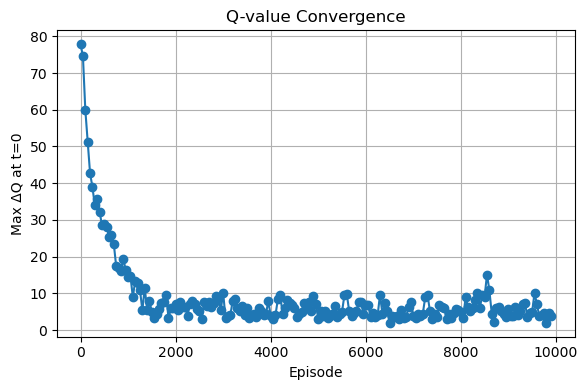


Time | Inv | Demand | Action
------------------------------------
   0 |    0 |      5 |      9
   1 |    4 |      6 |      9
   2 |    7 |      8 |      9
   3 |    8 |      3 |      9
   4 |   14 |      5 |      9
   5 |   18 |      0 |      9
   6 |   27 |      8 |      9
   7 |   28 |      4 |      9
   8 |   33 |      4 |      9
   9 |   38 |      3 |      9
  10 |   44 |      1 |      9
  11 |   50 |      4 |      9
  12 |   50 |      0 |      9
  13 |   50 |      0 |      9
  14 |   50 |      6 |      9
  15 |   50 |      8 |      9
  16 |   50 |      0 |      9
  17 |   50 |      5 |      9
  18 |   50 |      9 |      9
  19 |   50 |      9 |      9
  20 |   50 |      2 |      9
  21 |   50 |     10 |      9
  22 |   49 |      2 |      9
  23 |   50 |      7 |      9
  24 |   50 |      0 |      9
  25 |   50 |      7 |      9
  26 |   50 |      5 |      9
  27 |   50 |      3 |      9
  28 |   50 |      2 |      9
  29 |   50 |      2 |      9
  30 |   50 |      4 |      9
  3

/tmp/ipykernel_8151/6845966.py:222: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  w.append_data(imageio.imread(f"frames/{t:03d}.png"))


In [ ]:
import os, random, imageio, shutil
from collections import deque

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange

# -----------------------
# 1) ENVIRONMENT
# -----------------------
class InventoryEnv:
    def __init__(self, min_inv=-50, max_inv=50, T=50):
        self.min_inv = min_inv
        self.max_inv = max_inv
        self.T       = T
        self.reset()

    def reset(self):
        self.s = random.randint(self.min_inv, self.max_inv)
        self.t = 0
        return np.array([self.s, self.t], dtype=np.float32)

    def step(self, a):
        w = random.randint(0, 10)
        s2 = self.s + a - w
        s2 = max(self.min_inv, min(self.max_inv, s2))

        p, a_cost, b_cost = 1, 1, 2
        order_cost = p * a
        inv_cost   = a_cost * s2 if s2 >= 0 else b_cost * (-s2)
        cost       = order_cost + inv_cost
        r = cost

        self.t += 1
        done = (self.t >= self.T)
        self.s = s2
        obs = np.array([self.s, self.t if not done else 0], dtype=np.float32)
        return obs, r, done

# -----------------------
# 2) Q-NETWORK
# -----------------------
class DQN(nn.Module):
    def __init__(self, state_dim, num_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_actions)
        )
    def forward(self, x):
        return self.net(x)

# -----------------------
# 3) REPLAY BUFFER
# -----------------------
class ReplayBuffer:
    def __init__(self, cap): self.buf = deque(maxlen=cap)
    def push(self, *args):    self.buf.append(tuple(args))
    def sample(self, k):
        batch = random.sample(self.buf, k)
        return zip(*batch)
    def __len__(self): return len(self.buf)

# -----------------------
# 4) HYPERPARAMETERS
# -----------------------
num_actions      = 10
state_dim        = 2
T                = 50
min_inv, max_inv = -50, 50
gamma            = 1.0
eps_start        = 0.9
eps_end          = 0.05
eps_decay        = 5000
buffer_cap       = 50_000
batch_size       = 32
lr               = 1e-3
target_update    = 10
episodes         = 10000

# -----------------------
# 5) SETUP
# -----------------------
device     = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
env        = InventoryEnv(min_inv, max_inv, T)
policy_net = DQN(state_dim, num_actions).to(device)
target_net = DQN(state_dim, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
opt        = optim.Adam(policy_net.parameters(), lr=lr)
buf        = ReplayBuffer(buffer_cap)

step_count = 0
eps        = eps_start

# For Q-value convergence check
q_convergence = []
prev_q_snapshot = None
check_convergence_interval = 50

# -----------------------
# 6) TRAIN
# -----------------------
for ep in trange(episodes, desc="Training"):
    obs = env.reset()
    done= False
    while not done:
        if random.random() < eps:
            a = random.randrange(num_actions)
        else:
            st = torch.FloatTensor(obs).unsqueeze(0).to(device)
            qv = policy_net(st)
            a  = int(qv.argmin(dim=1).item())

        obs2, r, done = env.step(a)
        buf.push(obs, a, r, obs2, done)
        obs = obs2

        if len(buf) >= batch_size:
            s_batch, a_batch, r_batch, s2_batch, d_batch = buf.sample(batch_size)
            s_v  = torch.FloatTensor(s_batch).to(device)
            a_v  = torch.LongTensor(a_batch).to(device)
            r_v  = torch.FloatTensor(r_batch).to(device)
            s2_v = torch.FloatTensor(s2_batch).to(device)
            d_v  = torch.FloatTensor(d_batch).to(device)

            q_vals = policy_net(s_v).gather(1, a_v.unsqueeze(-1)).squeeze(-1)
            with torch.no_grad():
                q2 = target_net(s2_v)
                q2_min = q2.min(dim=1)[0]
                target = r_v + gamma * q2_min * (1 - d_v)

            loss = nn.MSELoss()(q_vals, target)
            opt.zero_grad(); loss.backward(); opt.step()

            step_count += 1
            if step_count % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

    # Don't decay ε
    eps = eps

    # Check Q-value convergence
    if ep % check_convergence_interval == 0:
        with torch.no_grad():
            q_snapshot = []
            for i, s in enumerate(range(min_inv, max_inv+1)):
                st = torch.FloatTensor([[s, 0]]).to(device)
                qs = policy_net(st).cpu().numpy()[0]
                q_snapshot.append(qs)
            q_snapshot = np.array(q_snapshot)

        if prev_q_snapshot is not None:
            diff = np.abs(prev_q_snapshot - q_snapshot)
            max_diff = np.max(diff)
            q_convergence.append(max_diff)
            print(f"[Episode {ep}] Max Q-value diff at t=0: {max_diff:.6f}")
        prev_q_snapshot = q_snapshot

print("Training complete")

# -----------------------
# Plot Q-value convergence
# -----------------------
if q_convergence:
    plt.figure(figsize=(6, 4))
    plt.plot(np.arange(len(q_convergence)) * check_convergence_interval, q_convergence, marker='o')
    plt.xlabel("Episode")
    plt.ylabel("Max ΔQ at t=0")
    plt.title("Q-value Convergence")
    plt.grid()
    plt.tight_layout()
    plt.show()

# -----------------------
# 7) EXTRACT Q-TABLE & V(s,t)
# -----------------------
policy_net.eval()
num_states = max_inv - min_inv + 1
Q_tab  = np.zeros((T, num_states, num_actions), dtype=np.float32)
V_tab  = np.zeros((T, num_states), dtype=np.float32)
pi_tab = np.zeros((T, num_states), dtype=int)

with torch.no_grad():
    for t in range(T):
        for i, s in enumerate(range(min_inv, max_inv+1)):
            st = torch.FloatTensor([[s, t]]).to(device)
            qs = policy_net(st).cpu().numpy()[0]
            Q_tab[t, i] = qs
            a_opt = int(np.argmin(qs))
            pi_tab[t, i] = a_opt
            V_tab[t, i] = qs[a_opt]

# -----------------------
# 9) ROLLOUT DEMO
# -----------------------
print("\nTime | Inv | Demand | Action")
print("------------------------------------")
s = 0
for t in range(T):
    w = random.randint(0,10)
    a = pi_tab[t, s-min_inv]
    print(f"{t:4d} | {s:4d} | {w:6d} | {a:6d}")
    s = max(min_inv, min(max_inv, s + a - w))

# -----------------------
# 11) GIF of V(s) over t
# -----------------------
states = np.arange(min_inv, max_inv+1)
os.makedirs("frames", exist_ok=True)
for t in range(T):
    plt.figure(figsize=(4,3))
    plt.plot(states, V_tab[t], marker='o')
    plt.title(f"t={t}"); plt.tight_layout()
    fn = f"frames/{t:03d}.png"
    plt.savefig(fn); plt.close()

with imageio.get_writer("vf_evolution_ar_22.gif", mode="I", duration=0.1) as w:
    for t in range(T):
        w.append_data(imageio.imread(f"frames/{t:03d}.png"))

shutil.rmtree("frames")

print("GIF saved as vf_evolution_ar_22.gif")

In [22]:
states = np.arange(min_inv, max_inv+1)
os.makedirs("frames", exist_ok=True)
for t in range(T):
    plt.figure(figsize=(4,3))
    plt.plot(states, V_tab[t], marker='o')
    plt.title(f"t={t}"); plt.tight_layout()
    fn = f"frames/{t:03d}.png"
    plt.savefig(fn); plt.close()

with imageio.get_writer("vf_evolution_ar_14.gif", mode="I", duration=0.1) as w:
    for t in range(T):
        w.append_data(imageio.imread(f"frames/{t:03d}.png"))

shutil.rmtree("frames")

print("GIF saved as vf_evolution_ar_14.gif")

/tmp/ipykernel_37148/3707170877.py:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  w.append_data(imageio.imread(f"frames/{t:03d}.png"))


GIF saved as vf_evolution_ar_14.gif


Without replay bufferr

cuda


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

/home/swaroop/Downloads/ENTER/lib/python3.12/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Training:   1%|          | 56/10000 [00:04<05:26, 30.48it/s]

[Ep 50] max ΔQ(t=0) = 877.788696


Training:   1%|          | 104/10000 [00:06<04:56, 33.36it/s]

[Ep 100] max ΔQ(t=0) = 210.984985


Training:   2%|▏         | 156/10000 [00:10<07:26, 22.06it/s]

[Ep 150] max ΔQ(t=0) = 169.820557


Training:   2%|▏         | 204/10000 [00:11<04:51, 33.56it/s]

[Ep 200] max ΔQ(t=0) = 342.622925


Training:   3%|▎         | 252/10000 [00:15<22:48,  7.13it/s]

[Ep 250] max ΔQ(t=0) = 262.266907


Training:   3%|▎         | 302/10000 [00:22<17:23,  9.30it/s]

[Ep 300] max ΔQ(t=0) = 224.435913


Training:   4%|▎         | 352/10000 [00:29<21:47,  7.38it/s]

[Ep 350] max ΔQ(t=0) = 309.589722


Training:   4%|▍         | 402/10000 [00:35<17:38,  9.07it/s]

[Ep 400] max ΔQ(t=0) = 325.359375


Training:   5%|▍         | 453/10000 [00:40<15:18, 10.39it/s]

[Ep 450] max ΔQ(t=0) = 147.186157


Training:   5%|▌         | 502/10000 [00:45<16:01,  9.88it/s]

[Ep 500] max ΔQ(t=0) = 174.911438


Training:   6%|▌         | 552/10000 [00:51<20:19,  7.74it/s]

[Ep 550] max ΔQ(t=0) = 211.367249


Training:   6%|▌         | 602/10000 [00:56<19:09,  8.17it/s]

[Ep 600] max ΔQ(t=0) = 246.520691


Training:   7%|▋         | 655/10000 [01:01<07:32, 20.67it/s]

[Ep 650] max ΔQ(t=0) = 225.969727


Training:   7%|▋         | 702/10000 [01:06<17:56,  8.64it/s]

[Ep 700] max ΔQ(t=0) = 354.913818


Training:   8%|▊         | 753/10000 [01:11<14:28, 10.64it/s]

[Ep 750] max ΔQ(t=0) = 262.705994


Training:   8%|▊         | 802/10000 [01:15<15:51,  9.67it/s]

[Ep 800] max ΔQ(t=0) = 194.499207


Training:   9%|▊         | 852/10000 [01:20<14:30, 10.51it/s]

[Ep 850] max ΔQ(t=0) = 210.813721


Training:   9%|▉         | 903/10000 [01:25<15:34,  9.74it/s]

[Ep 900] max ΔQ(t=0) = 103.779114


Training:  10%|▉         | 952/10000 [01:31<15:40,  9.62it/s]

[Ep 950] max ΔQ(t=0) = 220.007568


Training:  10%|█         | 1002/10000 [01:36<17:26,  8.60it/s]

[Ep 1000] max ΔQ(t=0) = 167.995483


Training:  11%|█         | 1052/10000 [01:42<16:00,  9.31it/s]

[Ep 1050] max ΔQ(t=0) = 219.232971


Training:  11%|█         | 1102/10000 [01:47<17:07,  8.66it/s]

[Ep 1100] max ΔQ(t=0) = 250.654846


Training:  12%|█▏        | 1152/10000 [01:53<16:00,  9.21it/s]

[Ep 1150] max ΔQ(t=0) = 254.921265


Training:  12%|█▏        | 1202/10000 [01:57<15:20,  9.56it/s]

[Ep 1200] max ΔQ(t=0) = 400.028198


Training:  13%|█▎        | 1252/10000 [02:03<16:29,  8.84it/s]

[Ep 1250] max ΔQ(t=0) = 350.880981


Training:  13%|█▎        | 1302/10000 [02:09<16:02,  9.03it/s]

[Ep 1300] max ΔQ(t=0) = 82.346558


Training:  14%|█▎        | 1352/10000 [02:14<16:38,  8.66it/s]

[Ep 1350] max ΔQ(t=0) = 356.950073


Training:  14%|█▍        | 1407/10000 [02:16<04:22, 32.72it/s]

[Ep 1400] max ΔQ(t=0) = 285.795410


Training:  15%|█▍        | 1455/10000 [02:18<04:20, 32.84it/s]

[Ep 1450] max ΔQ(t=0) = 196.520752


Training:  15%|█▌        | 1507/10000 [02:19<04:21, 32.53it/s]

[Ep 1500] max ΔQ(t=0) = 133.402466


Training:  16%|█▌        | 1555/10000 [02:21<04:27, 31.59it/s]

[Ep 1550] max ΔQ(t=0) = 181.249512


Training:  16%|█▌        | 1607/10000 [02:22<04:23, 31.86it/s]

[Ep 1600] max ΔQ(t=0) = 84.108887


Training:  17%|█▋        | 1651/10000 [02:25<16:46,  8.30it/s]

[Ep 1650] max ΔQ(t=0) = 149.550476


Training:  17%|█▋        | 1703/10000 [02:33<16:44,  8.26it/s]

[Ep 1700] max ΔQ(t=0) = 193.241211


Training:  18%|█▊        | 1752/10000 [02:38<13:44, 10.00it/s]

[Ep 1750] max ΔQ(t=0) = 185.224121


Training:  18%|█▊        | 1802/10000 [02:44<18:36,  7.34it/s]

[Ep 1800] max ΔQ(t=0) = 267.742554


Training:  19%|█▊        | 1852/10000 [02:50<15:09,  8.95it/s]

[Ep 1850] max ΔQ(t=0) = 143.187378


Training:  19%|█▉        | 1902/10000 [02:55<12:46, 10.57it/s]

[Ep 1900] max ΔQ(t=0) = 120.260132


Training:  20%|█▉        | 1952/10000 [03:00<13:57,  9.61it/s]

[Ep 1950] max ΔQ(t=0) = 69.363495


Training:  20%|██        | 2003/10000 [03:07<15:22,  8.67it/s]

[Ep 2000] max ΔQ(t=0) = 145.066986


Training:  21%|██        | 2052/10000 [03:12<15:11,  8.72it/s]

[Ep 2050] max ΔQ(t=0) = 138.820618


Training:  21%|██        | 2102/10000 [03:18<14:04,  9.35it/s]

[Ep 2100] max ΔQ(t=0) = 297.251099


Training:  22%|██▏       | 2153/10000 [03:23<12:26, 10.52it/s]

[Ep 2150] max ΔQ(t=0) = 153.482056


Training:  22%|██▏       | 2203/10000 [03:28<12:33, 10.35it/s]

[Ep 2200] max ΔQ(t=0) = 123.056274


Training:  23%|██▎       | 2251/10000 [03:32<12:40, 10.19it/s]

[Ep 2250] max ΔQ(t=0) = 136.029541


Training:  23%|██▎       | 2302/10000 [03:38<18:36,  6.90it/s]

[Ep 2300] max ΔQ(t=0) = 128.098572


Training:  24%|██▎       | 2356/10000 [03:44<04:45, 26.74it/s]

[Ep 2350] max ΔQ(t=0) = 51.139343


Training:  24%|██▍       | 2404/10000 [03:45<04:08, 30.57it/s]

[Ep 2400] max ΔQ(t=0) = 171.192200


Training:  25%|██▍       | 2455/10000 [03:47<04:42, 26.67it/s]

[Ep 2450] max ΔQ(t=0) = 134.510376


Training:  25%|██▌       | 2503/10000 [03:49<05:50, 21.39it/s]

[Ep 2500] max ΔQ(t=0) = 85.319336


Training:  26%|██▌       | 2555/10000 [03:51<03:47, 32.75it/s]

[Ep 2550] max ΔQ(t=0) = 94.274536


Training:  26%|██▌       | 2607/10000 [03:52<03:42, 33.20it/s]

[Ep 2600] max ΔQ(t=0) = 157.291016


Training:  27%|██▋       | 2655/10000 [03:54<04:20, 28.15it/s]

[Ep 2650] max ΔQ(t=0) = 46.970886


Training:  27%|██▋       | 2703/10000 [03:59<10:45, 11.30it/s]

[Ep 2700] max ΔQ(t=0) = 55.058655


Training:  28%|██▊       | 2753/10000 [04:03<10:33, 11.44it/s]

[Ep 2750] max ΔQ(t=0) = 112.859680


Training:  28%|██▊       | 2803/10000 [04:07<10:30, 11.41it/s]

[Ep 2800] max ΔQ(t=0) = 303.745178


Training:  29%|██▊       | 2853/10000 [04:12<10:05, 11.80it/s]

[Ep 2850] max ΔQ(t=0) = 127.509033


Training:  29%|██▉       | 2904/10000 [04:14<03:41, 32.08it/s]

[Ep 2900] max ΔQ(t=0) = 118.104492


Training:  30%|██▉       | 2955/10000 [04:16<04:05, 28.71it/s]

[Ep 2950] max ΔQ(t=0) = 226.201233


Training:  30%|███       | 3006/10000 [04:19<04:22, 26.63it/s]

[Ep 3000] max ΔQ(t=0) = 133.346436


Training:  31%|███       | 3057/10000 [04:21<03:53, 29.75it/s]

[Ep 3050] max ΔQ(t=0) = 253.221558


Training:  31%|███       | 3105/10000 [04:23<03:27, 33.25it/s]

[Ep 3100] max ΔQ(t=0) = 236.550537


Training:  32%|███▏      | 3157/10000 [04:24<03:26, 33.15it/s]

[Ep 3150] max ΔQ(t=0) = 201.351196


Training:  32%|███▏      | 3205/10000 [04:26<03:26, 32.88it/s]

[Ep 3200] max ΔQ(t=0) = 154.089722


Training:  33%|███▎      | 3253/10000 [04:30<06:30, 17.28it/s]

[Ep 3250] max ΔQ(t=0) = 93.920532


Training:  33%|███▎      | 3306/10000 [04:32<03:25, 32.56it/s]

[Ep 3300] max ΔQ(t=0) = 106.000977


Training:  34%|███▎      | 3355/10000 [04:33<04:37, 23.92it/s]

[Ep 3350] max ΔQ(t=0) = 87.014038


Training:  34%|███▍      | 3403/10000 [04:36<05:08, 21.41it/s]

[Ep 3400] max ΔQ(t=0) = 122.486877


Training:  35%|███▍      | 3452/10000 [04:38<08:03, 13.54it/s]

[Ep 3450] max ΔQ(t=0) = 166.052979


Training:  35%|███▌      | 3506/10000 [04:42<03:39, 29.59it/s]

[Ep 3500] max ΔQ(t=0) = 277.479187


Training:  36%|███▌      | 3554/10000 [04:43<03:20, 32.15it/s]

[Ep 3550] max ΔQ(t=0) = 317.364380


Training:  36%|███▌      | 3606/10000 [04:45<03:14, 32.87it/s]

[Ep 3600] max ΔQ(t=0) = 220.000061


Training:  37%|███▋      | 3651/10000 [04:47<10:45,  9.84it/s]

[Ep 3650] max ΔQ(t=0) = 136.732727


Training:  37%|███▋      | 3702/10000 [04:55<16:41,  6.29it/s]

[Ep 3700] max ΔQ(t=0) = 135.396240


Training:  38%|███▊      | 3752/10000 [05:03<16:27,  6.32it/s]

[Ep 3750] max ΔQ(t=0) = 323.950073


Training:  38%|███▊      | 3802/10000 [05:10<16:20,  6.32it/s]

[Ep 3800] max ΔQ(t=0) = 202.295288


Training:  39%|███▊      | 3852/10000 [05:18<16:18,  6.28it/s]

[Ep 3850] max ΔQ(t=0) = 222.665527


Training:  39%|███▉      | 3905/10000 [05:24<05:05, 19.94it/s]

[Ep 3900] max ΔQ(t=0) = 178.439514


Training:  40%|███▉      | 3957/10000 [05:26<03:18, 30.43it/s]

[Ep 3950] max ΔQ(t=0) = 48.161255


Training:  40%|████      | 4004/10000 [05:27<03:57, 25.22it/s]

[Ep 4000] max ΔQ(t=0) = 150.476074


Training:  41%|████      | 4053/10000 [05:33<09:18, 10.65it/s]

[Ep 4050] max ΔQ(t=0) = 218.578369


Training:  41%|████      | 4103/10000 [05:38<08:54, 11.03it/s]

[Ep 4100] max ΔQ(t=0) = 186.370605


Training:  42%|████▏     | 4153/10000 [05:42<08:45, 11.12it/s]

[Ep 4150] max ΔQ(t=0) = 275.730713


Training:  42%|████▏     | 4203/10000 [05:47<08:34, 11.27it/s]

[Ep 4200] max ΔQ(t=0) = 149.237854


Training:  43%|████▎     | 4253/10000 [05:51<08:35, 11.14it/s]

[Ep 4250] max ΔQ(t=0) = 58.094177


Training:  43%|████▎     | 4303/10000 [05:56<08:26, 11.25it/s]

[Ep 4300] max ΔQ(t=0) = 116.138000


Training:  44%|████▎     | 4353/10000 [06:00<08:10, 11.51it/s]

[Ep 4350] max ΔQ(t=0) = 49.460693


Training:  44%|████▍     | 4403/10000 [06:05<08:25, 11.06it/s]

[Ep 4400] max ΔQ(t=0) = 155.662537


Training:  45%|████▍     | 4452/10000 [06:10<10:54,  8.47it/s]

[Ep 4450] max ΔQ(t=0) = 384.030457


Training:  45%|████▌     | 4501/10000 [06:15<13:57,  6.57it/s]

[Ep 4500] max ΔQ(t=0) = 244.965332


Training:  46%|████▌     | 4552/10000 [06:20<08:38, 10.51it/s]

[Ep 4550] max ΔQ(t=0) = 88.553711


Training:  46%|████▌     | 4602/10000 [06:24<08:08, 11.06it/s]

[Ep 4600] max ΔQ(t=0) = 237.946472


Training:  47%|████▋     | 4652/10000 [06:29<08:07, 10.97it/s]

[Ep 4650] max ΔQ(t=0) = 196.540283


Training:  47%|████▋     | 4702/10000 [06:33<07:57, 11.11it/s]

[Ep 4700] max ΔQ(t=0) = 191.445557


Training:  48%|████▊     | 4752/10000 [06:38<07:47, 11.23it/s]

[Ep 4750] max ΔQ(t=0) = 169.119812


Training:  48%|████▊     | 4802/10000 [06:42<07:47, 11.11it/s]

[Ep 4800] max ΔQ(t=0) = 67.877014


Training:  49%|████▊     | 4852/10000 [06:47<08:17, 10.35it/s]

[Ep 4850] max ΔQ(t=0) = 87.932983


Training:  49%|████▉     | 4902/10000 [06:52<07:54, 10.75it/s]

[Ep 4900] max ΔQ(t=0) = 118.128906


Training:  50%|████▉     | 4952/10000 [06:56<07:36, 11.06it/s]

[Ep 4950] max ΔQ(t=0) = 95.736755


Training:  50%|█████     | 5002/10000 [07:01<07:23, 11.26it/s]

[Ep 5000] max ΔQ(t=0) = 108.251465


Training:  51%|█████     | 5052/10000 [07:05<07:25, 11.10it/s]

[Ep 5050] max ΔQ(t=0) = 164.301758


Training:  51%|█████     | 5107/10000 [07:09<02:57, 27.64it/s]

[Ep 5100] max ΔQ(t=0) = 89.390808


Training:  52%|█████▏    | 5152/10000 [07:12<07:17, 11.09it/s]

[Ep 5150] max ΔQ(t=0) = 115.405334


Training:  52%|█████▏    | 5202/10000 [07:16<07:10, 11.13it/s]

[Ep 5200] max ΔQ(t=0) = 187.370483


Training:  53%|█████▎    | 5252/10000 [07:21<07:11, 11.01it/s]

[Ep 5250] max ΔQ(t=0) = 330.186096


Training:  53%|█████▎    | 5302/10000 [07:26<09:11,  8.51it/s]

[Ep 5300] max ΔQ(t=0) = 152.041809


Training:  54%|█████▎    | 5351/10000 [07:31<07:42, 10.04it/s]

[Ep 5350] max ΔQ(t=0) = 132.597412


Training:  54%|█████▍    | 5405/10000 [07:35<03:52, 19.78it/s]

[Ep 5400] max ΔQ(t=0) = 111.691895


Training:  55%|█████▍    | 5457/10000 [07:37<02:56, 25.79it/s]

[Ep 5450] max ΔQ(t=0) = 147.581970


Training:  55%|█████▌    | 5505/10000 [07:39<02:41, 27.90it/s]

[Ep 5500] max ΔQ(t=0) = 392.676514


Training:  56%|█████▌    | 5555/10000 [07:41<02:52, 25.73it/s]

[Ep 5550] max ΔQ(t=0) = 412.664246


Training:  56%|█████▌    | 5603/10000 [07:46<06:22, 11.49it/s]

[Ep 5600] max ΔQ(t=0) = 133.387756


Training:  57%|█████▋    | 5652/10000 [07:49<06:57, 10.41it/s]

[Ep 5650] max ΔQ(t=0) = 132.959778


Training:  57%|█████▋    | 5703/10000 [07:55<06:51, 10.44it/s]

[Ep 5700] max ΔQ(t=0) = 136.576904


Training:  58%|█████▊    | 5752/10000 [07:59<06:41, 10.58it/s]

[Ep 5750] max ΔQ(t=0) = 89.033142


Training:  58%|█████▊    | 5803/10000 [08:05<06:32, 10.68it/s]

[Ep 5800] max ΔQ(t=0) = 110.477234


Training:  59%|█████▊    | 5853/10000 [08:09<06:32, 10.58it/s]

[Ep 5850] max ΔQ(t=0) = 63.717102


Training:  59%|█████▉    | 5902/10000 [08:14<06:26, 10.61it/s]

[Ep 5900] max ΔQ(t=0) = 246.231873


Training:  60%|█████▉    | 5952/10000 [08:19<06:26, 10.47it/s]

[Ep 5950] max ΔQ(t=0) = 153.299438


Training:  60%|██████    | 6003/10000 [08:24<06:16, 10.63it/s]

[Ep 6000] max ΔQ(t=0) = 109.137512


Training:  61%|██████    | 6052/10000 [08:29<06:11, 10.62it/s]

[Ep 6050] max ΔQ(t=0) = 405.109131


Training:  61%|██████    | 6102/10000 [08:34<06:06, 10.62it/s]

[Ep 6100] max ΔQ(t=0) = 556.946899


Training:  62%|██████▏   | 6153/10000 [08:39<05:41, 11.27it/s]

[Ep 6150] max ΔQ(t=0) = 92.129944


Training:  62%|██████▏   | 6206/10000 [08:43<02:29, 25.43it/s]

[Ep 6200] max ΔQ(t=0) = 233.161377


Training:  63%|██████▎   | 6254/10000 [08:45<02:00, 31.09it/s]

[Ep 6250] max ΔQ(t=0) = 73.444336


Training:  63%|██████▎   | 6302/10000 [08:49<06:02, 10.20it/s]

[Ep 6300] max ΔQ(t=0) = 138.846680


Training:  64%|██████▎   | 6352/10000 [08:55<06:29,  9.36it/s]

[Ep 6350] max ΔQ(t=0) = 100.331726


Training:  64%|██████▍   | 6402/10000 [09:01<06:55,  8.65it/s]

[Ep 6400] max ΔQ(t=0) = 332.358215


Training:  65%|██████▍   | 6454/10000 [09:07<04:09, 14.21it/s]

[Ep 6450] max ΔQ(t=0) = 113.841797


Training:  65%|██████▌   | 6504/10000 [09:09<01:50, 31.53it/s]

[Ep 6500] max ΔQ(t=0) = 301.518433


Training:  66%|██████▌   | 6556/10000 [09:10<01:49, 31.59it/s]

[Ep 6550] max ΔQ(t=0) = 163.540222


Training:  66%|██████▌   | 6604/10000 [09:12<02:15, 25.01it/s]

[Ep 6600] max ΔQ(t=0) = 121.095825


Training:  67%|██████▋   | 6652/10000 [09:16<05:13, 10.66it/s]

[Ep 6650] max ΔQ(t=0) = 184.946899


Training:  67%|██████▋   | 6702/10000 [09:21<05:00, 10.97it/s]

[Ep 6700] max ΔQ(t=0) = 220.698303


Training:  68%|██████▊   | 6752/10000 [09:25<04:52, 11.09it/s]

[Ep 6750] max ΔQ(t=0) = 150.638367


Training:  68%|██████▊   | 6801/10000 [09:28<03:07, 17.06it/s]

[Ep 6800] max ΔQ(t=0) = 183.087830


Training:  69%|██████▊   | 6852/10000 [09:33<05:04, 10.33it/s]

[Ep 6850] max ΔQ(t=0) = 197.239380


Training:  69%|██████▉   | 6902/10000 [09:38<04:44, 10.89it/s]

[Ep 6900] max ΔQ(t=0) = 272.802124


Training:  70%|██████▉   | 6952/10000 [09:42<04:41, 10.81it/s]

[Ep 6950] max ΔQ(t=0) = 50.132141


Training:  70%|███████   | 7002/10000 [09:47<04:36, 10.84it/s]

[Ep 7000] max ΔQ(t=0) = 114.569275


Training:  71%|███████   | 7052/10000 [09:51<04:30, 10.89it/s]

[Ep 7050] max ΔQ(t=0) = 50.201355


Training:  71%|███████   | 7102/10000 [09:57<07:25,  6.51it/s]

[Ep 7100] max ΔQ(t=0) = 62.358887


Training:  72%|███████▏  | 7152/10000 [10:03<07:28,  6.35it/s]

[Ep 7150] max ΔQ(t=0) = 152.122192


Training:  72%|███████▏  | 7202/10000 [10:10<05:27,  8.54it/s]

[Ep 7200] max ΔQ(t=0) = 147.856934


Training:  73%|███████▎  | 7252/10000 [10:16<05:19,  8.60it/s]

[Ep 7250] max ΔQ(t=0) = 217.646851


Training:  73%|███████▎  | 7303/10000 [10:21<04:14, 10.61it/s]

[Ep 7300] max ΔQ(t=0) = 96.866394


Training:  74%|███████▎  | 7353/10000 [10:26<04:05, 10.80it/s]

[Ep 7350] max ΔQ(t=0) = 44.180023


Training:  74%|███████▍  | 7403/10000 [10:30<04:04, 10.62it/s]

[Ep 7400] max ΔQ(t=0) = 99.267517


Training:  75%|███████▍  | 7453/10000 [10:35<03:17, 12.90it/s]

[Ep 7450] max ΔQ(t=0) = 181.401367


Training:  75%|███████▌  | 7507/10000 [10:37<01:25, 29.30it/s]

[Ep 7500] max ΔQ(t=0) = 105.305969


Training:  76%|███████▌  | 7555/10000 [10:38<01:20, 30.50it/s]

[Ep 7550] max ΔQ(t=0) = 168.123901


Training:  76%|███████▌  | 7602/10000 [10:42<05:23,  7.42it/s]

[Ep 7600] max ΔQ(t=0) = 151.944397


Training:  77%|███████▋  | 7652/10000 [10:47<03:41, 10.58it/s]

[Ep 7650] max ΔQ(t=0) = 192.053162


Training:  77%|███████▋  | 7702/10000 [10:52<03:37, 10.55it/s]

[Ep 7700] max ΔQ(t=0) = 120.313721


Training:  78%|███████▊  | 7753/10000 [10:56<02:39, 14.05it/s]

[Ep 7750] max ΔQ(t=0) = 181.381653


Training:  78%|███████▊  | 7802/10000 [11:01<03:25, 10.68it/s]

[Ep 7800] max ΔQ(t=0) = 113.129456


Training:  79%|███████▊  | 7853/10000 [11:03<01:16, 28.09it/s]

[Ep 7850] max ΔQ(t=0) = 85.148560


Training:  79%|███████▉  | 7905/10000 [11:05<01:06, 31.68it/s]

[Ep 7900] max ΔQ(t=0) = 116.961975


Training:  80%|███████▉  | 7953/10000 [11:07<01:42, 20.07it/s]

[Ep 7950] max ΔQ(t=0) = 63.447571


Training:  80%|████████  | 8006/10000 [11:11<01:29, 22.24it/s]

[Ep 8000] max ΔQ(t=0) = 98.042114


Training:  81%|████████  | 8054/10000 [11:12<01:17, 25.24it/s]

[Ep 8050] max ΔQ(t=0) = 211.454773


Training:  81%|████████  | 8103/10000 [11:16<01:53, 16.69it/s]

[Ep 8100] max ΔQ(t=0) = 54.948547


Training:  82%|████████▏ | 8153/10000 [11:20<03:00, 10.26it/s]

[Ep 8150] max ΔQ(t=0) = 104.090454


Training:  82%|████████▏ | 8203/10000 [11:25<02:45, 10.84it/s]

[Ep 8200] max ΔQ(t=0) = 140.164307


Training:  83%|████████▎ | 8253/10000 [11:29<02:39, 10.92it/s]

[Ep 8250] max ΔQ(t=0) = 162.836548


Training:  83%|████████▎ | 8301/10000 [11:32<01:21, 20.90it/s]

[Ep 8300] max ΔQ(t=0) = 215.776733


Training:  84%|████████▎ | 8352/10000 [11:37<02:36, 10.54it/s]

[Ep 8350] max ΔQ(t=0) = 176.652100


Training:  84%|████████▍ | 8402/10000 [11:41<02:39, 10.01it/s]

[Ep 8400] max ΔQ(t=0) = 97.018982


Training:  85%|████████▍ | 8455/10000 [11:46<01:13, 21.03it/s]

[Ep 8450] max ΔQ(t=0) = 154.302002


Training:  85%|████████▌ | 8503/10000 [11:50<02:20, 10.67it/s]

[Ep 8500] max ΔQ(t=0) = 260.376953


Training:  86%|████████▌ | 8553/10000 [11:55<02:15, 10.64it/s]

[Ep 8550] max ΔQ(t=0) = 151.230774


Training:  86%|████████▌ | 8603/10000 [11:59<01:51, 12.53it/s]

[Ep 8600] max ΔQ(t=0) = 97.613647


Training:  87%|████████▋ | 8657/10000 [12:01<00:47, 28.13it/s]

[Ep 8650] max ΔQ(t=0) = 112.677368


Training:  87%|████████▋ | 8707/10000 [12:03<00:42, 30.26it/s]

[Ep 8700] max ΔQ(t=0) = 217.751587


Training:  88%|████████▊ | 8755/10000 [12:05<00:41, 29.88it/s]

[Ep 8750] max ΔQ(t=0) = 113.108276


Training:  88%|████████▊ | 8802/10000 [12:08<02:35,  7.71it/s]

[Ep 8800] max ΔQ(t=0) = 121.898254


Training:  89%|████████▊ | 8857/10000 [12:14<00:53, 21.48it/s]

[Ep 8850] max ΔQ(t=0) = 143.608398


Training:  89%|████████▉ | 8904/10000 [12:16<00:35, 30.70it/s]

[Ep 8900] max ΔQ(t=0) = 100.312500


Training:  90%|████████▉ | 8956/10000 [12:17<00:32, 31.97it/s]

[Ep 8950] max ΔQ(t=0) = 92.961304


Training:  90%|█████████ | 9002/10000 [12:21<02:41,  6.18it/s]

[Ep 9000] max ΔQ(t=0) = 80.197754


Training:  91%|█████████ | 9053/10000 [12:26<01:31, 10.36it/s]

[Ep 9050] max ΔQ(t=0) = 105.970398


Training:  91%|█████████ | 9103/10000 [12:31<01:22, 10.84it/s]

[Ep 9100] max ΔQ(t=0) = 71.631958


Training:  92%|█████████▏| 9153/10000 [12:36<01:19, 10.59it/s]

[Ep 9150] max ΔQ(t=0) = 144.931091


Training:  92%|█████████▏| 9203/10000 [12:40<01:13, 10.78it/s]

[Ep 9200] max ΔQ(t=0) = 72.744507


Training:  93%|█████████▎| 9253/10000 [12:45<01:08, 10.93it/s]

[Ep 9250] max ΔQ(t=0) = 134.682312


Training:  93%|█████████▎| 9303/10000 [12:50<01:05, 10.57it/s]

[Ep 9300] max ΔQ(t=0) = 153.067688


Training:  94%|█████████▎| 9353/10000 [12:54<00:57, 11.35it/s]

[Ep 9350] max ΔQ(t=0) = 165.928162


Training:  94%|█████████▍| 9406/10000 [12:58<00:24, 24.66it/s]

[Ep 9400] max ΔQ(t=0) = 113.878601


Training:  95%|█████████▍| 9455/10000 [13:01<00:18, 28.77it/s]

[Ep 9450] max ΔQ(t=0) = 91.028687


Training:  95%|█████████▌| 9504/10000 [13:02<00:17, 28.23it/s]

[Ep 9500] max ΔQ(t=0) = 135.294250


Training:  96%|█████████▌| 9554/10000 [13:05<00:27, 16.12it/s]

[Ep 9550] max ΔQ(t=0) = 284.007446


Training:  96%|█████████▌| 9606/10000 [13:06<00:12, 31.26it/s]

[Ep 9600] max ΔQ(t=0) = 235.325256


Training:  97%|█████████▋| 9656/10000 [13:10<00:14, 23.66it/s]

[Ep 9650] max ΔQ(t=0) = 298.107056


Training:  97%|█████████▋| 9704/10000 [13:12<00:12, 24.59it/s]

[Ep 9700] max ΔQ(t=0) = 314.370850


Training:  98%|█████████▊| 9756/10000 [13:14<00:08, 30.23it/s]

[Ep 9750] max ΔQ(t=0) = 113.836426


Training:  98%|█████████▊| 9802/10000 [13:18<00:18, 10.78it/s]

[Ep 9800] max ΔQ(t=0) = 214.064087


Training:  99%|█████████▊| 9855/10000 [13:21<00:04, 29.10it/s]

[Ep 9850] max ΔQ(t=0) = 202.825073


Training:  99%|█████████▉| 9906/10000 [13:22<00:02, 31.56it/s]

[Ep 9900] max ΔQ(t=0) = 198.285217


Training: 100%|█████████▉| 9954/10000 [13:24<00:01, 32.00it/s]

[Ep 9950] max ΔQ(t=0) = 107.952881


Training: 100%|██████████| 10000/10000 [13:26<00:00, 12.40it/s]

✅ Training complete


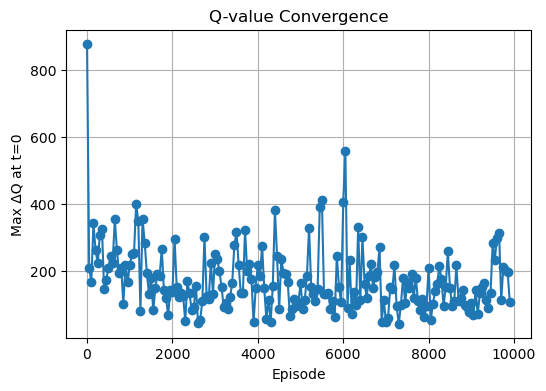


Period | σ_t
---------------
     0 |   17
     1 |   24
     2 |   31
     3 |   33
     4 |   34
     5 |   33
     6 |   32
     7 |   28
     8 |   23
     9 |   18
    10 |   14
    11 |   14
    12 |   14
    13 |   14
    14 |   13
    15 |   13
    16 |   13
    17 |   13
    18 |   13
    19 |   13
 ...

Time | Inv | σ_t | Demand | Action
------------------------------------
   0 |    0 |   17 |      4 |      9
   1 |    5 |   24 |      4 |      1
   2 |    2 |   31 |      9 |      4
   3 |   -3 |   33 |      7 |      9
   4 |   -1 |   34 |      0 |      4
   5 |    3 |   33 |      7 |      4
   6 |    0 |   32 |     10 |      4
   7 |   -6 |   28 |      0 |      9
   8 |    3 |   23 |      7 |      4
   9 |    0 |   18 |      8 |      4
  10 |   -4 |   14 |      1 |      7
  11 |    2 |   14 |      1 |      4
  12 |    5 |   14 |      3 |      2
  13 |    4 |   14 |      1 |      2
  14 |    5 |   13 |      0 |      2
  15 |    7 |   13 |      8 |      1
  16 |    0 |   13 |

/tmp/ipykernel_8151/3044253966.py:234: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(f"frames/{t:03d}.png"))


In [ ]:
import os, random, imageio, shutil
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange

# -----------------------
# 1) ENVIRONMENT
# -----------------------
class InventoryEnv:
    def __init__(self, min_inv=-50, max_inv=50, T=50):
        self.min_inv = min_inv
        self.max_inv = max_inv
        self.T       = T
        self.reset()

    def reset(self):
        self.s = random.randint(self.min_inv, self.max_inv)
        self.t = 0
        return np.array([self.s, self.t], dtype=np.float32)

    def step(self, a):
        w = random.randint(0, 10)
        s2 = self.s + a - w
        s2 = max(self.min_inv, min(self.max_inv, s2))

        # cost structure
        p, a_cost, b_cost = 1, 1, 2
        order_cost = p * a
        inv_cost   = a_cost * s2 if s2 >= 0 else b_cost * (-s2)
        cost       = order_cost + inv_cost

        self.t += 1
        done = (self.t >= self.T)
        self.s = s2
        obs2 = np.array([self.s, self.t if not done else 0], dtype=np.float32)
        return obs2, cost, done  # cost=r

# -----------------------
# 2) Q-NETWORK
# -----------------------
class DQN(nn.Module):
    def __init__(self, state_dim, num_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128), nn.ReLU(),
            nn.Linear(128, 128),       nn.ReLU(),
            nn.Linear(128, num_actions)
        )
    def forward(self, x):
        return self.net(x)

# -----------------------
# 3) HYPERPARAMETERS
# -----------------------
num_actions      = 10
state_dim        = 2
T                = 50
min_inv, max_inv = -50, 50
gamma            = 1.0
eps_start        = 0.9
eps_end          = 0.05
eps_decay        = 5000
lr               = 1e-3
target_update    = 10    # steps between target_net sync
episodes         = 10000

# -----------------------
# 4) SETUP
# -----------------------
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
env         = InventoryEnv(min_inv, max_inv, T)
policy_net  = DQN(state_dim, num_actions).to(device)
target_net  = DQN(state_dim, num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
opt         = optim.Adam(policy_net.parameters(), lr=lr)
mse_loss    = nn.MSELoss()

step_count      = 0
eps             = eps_start

# for Q-value convergence
q_convergence            = []
prev_q_snapshot          = None
check_convergence_every  = 50

# -----------------------
# 5) TRAIN (online)
# -----------------------
for ep in trange(episodes, desc="Training"):
    obs, done = env.reset(), False
    while not done:
        # ε-greedy: pick action that minimizes Q
        if random.random() < eps:
            a = random.randrange(num_actions)
        else:
            st = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
            qv = policy_net(st)
            a  = int(qv.argmin(dim=1).item())

        # step
        obs2, cost, done = env.step(a)
        # build tensors
        st_v   = torch.tensor(obs, dtype=torch.float32, device=device).unsqueeze(0)
        st2_v  = torch.tensor(obs2, dtype=torch.float32, device=device).unsqueeze(0)
        cost_v = torch.tensor([cost], dtype=torch.float32, device=device)

        # current Q(s,a)
        q_vals = policy_net(st_v)
        q_s_a  = q_vals[0, a]

        # compute TD target: cost + γ·min_a' Q_target(s2,a') if not done
        with torch.no_grad():
            q2     = target_net(st2_v)
            q2_min = q2.min(dim=1)[0]
            target = cost_v + gamma * q2_min * (0.0 if done else 1.0)

        # loss & backward
        loss = mse_loss(q_s_a, target)
        opt.zero_grad()
        loss.backward()
        opt.step()

        obs = obs2
        step_count += 1

        # sync target
        if step_count % target_update == 0:
            target_net.load_state_dict(policy_net.state_dict())

    # ε-decay
    eps = max(eps_end, eps_start * np.exp(-ep/eps_decay))

    # Q-value convergence check
    if ep % check_convergence_every == 0:
        with torch.no_grad():
            snapshot = []
            for s in range(min_inv, max_inv+1):
                st = torch.tensor([s, 0], dtype=torch.float32, device=device).unsqueeze(0)
                qs = policy_net(st)[0].cpu().numpy()
                snapshot.append(qs)
            snapshot = np.array(snapshot)
        if prev_q_snapshot is not None:
            diff = np.max(np.abs(snapshot - prev_q_snapshot))
            q_convergence.append(diff)
            print(f"[Ep {ep}] max ΔQ(t=0) = {diff:.6f}")
        prev_q_snapshot = snapshot

print("✅ Training complete")

# -----------------------
# Plot Q-value convergence
# -----------------------
if q_convergence:
    plt.figure(figsize=(6,4))
    plt.plot(np.arange(len(q_convergence))*check_convergence_every, q_convergence, marker='o')
    plt.xlabel("Episode")
    plt.ylabel("Max ΔQ at t=0")
    plt.title("Q-value Convergence")
    plt.grid(True)
    plt.show()

# -----------------------
# 6) EXTRACT Q-TABLE & POLICY
# -----------------------
policy_net.eval()
num_states = max_inv - min_inv + 1
Q_tab      = np.zeros((T, num_states, num_actions), dtype=np.float32)
V_tab      = np.zeros((T, num_states), dtype=np.float32)
pi_tab     = np.zeros((T, num_states), dtype=int)

with torch.no_grad():
    for t in range(T):
        for i, s in enumerate(range(min_inv, max_inv+1)):
            st = torch.tensor([s, t], dtype=torch.float32, device=device).unsqueeze(0)
            qs = policy_net(st)[0].cpu().numpy()
            Q_tab[t, i]  = qs
            pi_tab[t, i] = int(np.argmin(qs))
            V_tab[t, i]  = np.min(qs)

# -----------------------
# 7) Compute Base-Stock σ_t
# -----------------------
sigma = []
for t in range(T):
    row = pi_tab[t]
    th  = max_inv
    for i, a in enumerate(row):
        s = i + min_inv
        if a == 0:      # action 0 = “no order”
            th = s
            break
    sigma.append(th)

print("\nPeriod | σ_t")
print("---------------")
for t, z in enumerate(sigma[:20]):
    print(f"{t:6d} | {z:4d}")
print(" ...")

# -----------------------
# 8) Rollout Demo
# -----------------------
print("\nTime | Inv | σ_t | Demand | Action")
print("------------------------------------")
s = 0
for t in range(T):
    w = random.randint(0,10)
    a = pi_tab[t, s - min_inv]
    print(f"{t:4d} | {s:4d} | {sigma[t]:4d} | {w:6d} | {a:6d}")
    s = max(min_inv, min(max_inv, s + a - w))

# -----------------------
# 9) GIF of V(s) evolution
# -----------------------
os.makedirs("frames", exist_ok=True)
states = np.arange(min_inv, max_inv+1)
for t in range(T):
    plt.figure(figsize=(4,3))
    plt.plot(states, V_tab[t], marker='o')
    plt.title(f"t={t}")
    plt.xlabel("Inventory")
    plt.ylabel("V(s,t)")
    plt.grid(True)
    fn = f"frames/{t:03d}.png"
    plt.savefig(fn)
    plt.close()

with imageio.get_writer("vf_evolution_no_buffer.gif", mode="I", duration=0.1) as writer:
    for t in range(T):
        writer.append_data(imageio.imread(f"frames/{t:03d}.png"))
shutil.rmtree("frames")

print("GIF saved as vf_evolution_no_buffer.gif")
